In [1]:
import pickle
import json
import sys
import re
import os
import psutil
from functools import lru_cache
import time

from pathlib import Path
from tqdm import tqdm

from collections import Counter, OrderedDict, namedtuple
from functools import reduce

import pandas as pd
import numpy as np

import einops
from einops.layers.torch import Rearrange, Reduce

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.data import get_tokenizer
from torchtext.vocab import vocab

from random import randint
import random


from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

PROJECT_DIR = Path().absolute().parent
WIKI_PATH = PROJECT_DIR / 'InputData' / 'wikitext-103'
DATA_PATH = PROJECT_DIR / 'Data'

sys.path.append(str(PROJECT_DIR))

In [2]:
def process_memory():
    process = psutil.Process(os.getpid())
    print(f'{round(process.memory_info().rss * 10**(-6))} MB')

def objects_memory(*args):
    print(f'{round(sum([sys.getsizeof(obj) for obj in args]) * 10**(-6))} MB')

In [3]:
def save_pkl(obj, pth):
    with open(pth, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_pkl(pth):
    with open(pth, 'rb') as f:
        return pickle.load(f)

In [4]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    Regex,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast

# Load Data

In [4]:
def load_data(tp='train'):
    if tp not in ['train', 'test', 'valid']:
        raise Exception('ERROR: Wrong type of data.')
    
    pth = WIKI_PATH / f'wiki.{tp}.raw'
    heading_pattern = '\n (= ){1,}[^=]*[^=] (= ){1,}\n \n'
    with open(pth, 'r') as f:
        raw_text = f.read()
    
    raw_text = re.split(heading_pattern, raw_text)
    raw_text = [x.strip().strip('\n').strip() for x in raw_text if x and x not in [' ', '= ']]
    return raw_text

In [5]:
%%time
train_data = load_data('train')
test_data = load_data('test')
valid_data = load_data('valid')

print(f'{len(train_data)}/{len(test_data)}/{len(valid_data)}')

271821/623/552
CPU times: user 4.41 s, sys: 2.55 s, total: 6.96 s
Wall time: 7.01 s


In [6]:
def get_training_corpus():
    for i in range(0, len(train_data), 1000):
        yield train_data[i : i + 1000]

# Build Alphabet

In [7]:
tmp_tokenizer = Tokenizer(models.Unigram())
tmp_tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("‚Äù", '"'),
        normalizers.Replace("‚Äú", '"'),
        normalizers.Replace('Àà', "'"),
        normalizers.Replace('‚Äô',"'"),
        normalizers.Replace('‚Äì',"-"),
        normalizers.Replace('‚Äî',"-"),
        normalizers.Replace('‚àí',"-"),
        normalizers.Replace('‚Ä≤',"'"),
        normalizers.Replace('‚ÅÑ',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)
tmp_tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
    [
        pre_tokenizers.BertPreTokenizer(), 
        # pre_tokenizers.Metaspace(replacement = '_', add_prefix_space = True),
        # pre_tokenizers.Punctuation(),
        pre_tokenizers.Digits(individual_digits=True)
    ]
)

In [8]:
char_counter = Counter()
for i in tqdm(range(len(train_data))):
    art_counter = Counter(train_data[i])
    char_counter.update(art_counter)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 271821/271821 [00:26<00:00, 10241.82it/s]


In [9]:
char_counter_df = pd.DataFrame(char_counter.most_common(), columns=['Symbol', 'Count'])
char_counter_df.shape

(4978, 2)

In [10]:
def get_base_char(txt):
    tokens = tmp_tokenizer.encode(txt).tokens
    return tokens
char_counter_df['Base_Symbol'] = char_counter_df['Symbol'].apply(get_base_char)
char_counter_df['Base_Symbol'].apply(len).value_counts()

1    4735
0     229
3      11
2       2
4       1
Name: Base_Symbol, dtype: int64

In [11]:
char_counter_df[char_counter_df['Base_Symbol'].apply(len) > 1]

Symbol  Count              Base_Symbol
122       ‚Ä¶   1961                [., ., .]
172       ¬Ω    757                [1, ‚ÅÑ, 2]
202       ‚Ä≥    535                   [‚Ä≤, ‚Ä≤]
468       ‚Öì     86                [1, ‚ÅÑ, 3]
568       ‚Öî     58                [2, ‚ÅÑ, 3]
591       ¬º     55                [1, ‚ÅÑ, 4]
592       ¬æ     55                [3, ‚ÅÑ, 4]
1310      ‚Öú     11                [3, ‚ÅÑ, 8]
1468      ‚Öõ      9                [1, ‚ÅÑ, 8]
1482      ‚Öù      9                [5, ‚ÅÑ, 8]
2580      ‚Öû      3                [7, ‚ÅÑ, 8]
2599      ‚Äº      3                   [!, !]
3359      Ô∑∫      2  [ÿµŸÑŸâ, ÿßŸÑŸÑŸá, ÿπŸÑŸäŸá, Ÿàÿ≥ŸÑŸÖ]
4238      ‚Öô      1                [1, ‚ÅÑ, 6]

In [12]:
char_counter_df['Single_Base_Symbol'] = char_counter_df['Base_Symbol'].apply(lambda x: x[0] if x else '')
char_counter_df

Symbol     Count Base_Symbol Single_Base_Symbol
0            99530965          []                   
1         e  48657548         [e]                  e
2         t  33788437         [t]                  t
3         a  33364371         [a]                  a
4         n  28965321         [n]                  n
...     ...       ...         ...                ...
4973      Ë™≤         1         [Ë™≤]                  Ë™≤
4974      Á¥î         1         [Á¥î]                  Á¥î
4975      ‰∏Ω         1         [‰∏Ω]                  ‰∏Ω
4976      Ïπò         1        [·Ñé·Öµ]                 ·Ñé·Öµ
4977      ÌÇ®         1       [·Ñè·Öµ·Ü´]                ·Ñè·Öµ·Ü´

[4978 rows x 4 columns]

In [13]:
char_counter_df = char_counter_df.groupby('Single_Base_Symbol')['Count'].sum().reset_index()
char_counter_df = char_counter_df.sort_values('Count', ascending=False).reset_index(drop=True)
char_counter_df

Single_Base_Symbol      Count
0                        100128792
1                     e   48715319
2                     t   33789131
3                     a   33401452
4                     n   28970107
...                 ...        ...
4195                  ÊÅ¢          1
4196                  ÊÅí          1
4197                  ÊÅÜ          1
4198                  ÊÄ®          1
4199                  üñï          1

[4200 rows x 2 columns]

In [14]:
char_counter_df['Cum_Prc'] = (char_counter_df['Count'] / char_counter_df['Count'].sum()).cumsum()

In [65]:
char_counter_df.head(110).tail(60)

Single_Base_Symbol   Count   Cum_Prc
50                   )  572467  0.984419
51                   (  572111  0.985501
52                   3  541764  0.986526
53                   5  538413  0.987544
54                   8  532060  0.988550
55                   E  514159  0.989523
56                   J  503445  0.990475
57                   4  495231  0.991412
58                   O  462139  0.992286
59                   6  445885  0.993129
60                   7  442039  0.993965
61                   z  418318  0.994757
62                   j  379936  0.995475
63                   K  347264  0.996132
64                   q  339468  0.996774
65                   U  311682  0.997364
66                   V  254111  0.997844
67                   ;  190871  0.998205
68                   :  176460  0.998539
69                   Y  144573  0.998812
70                   /   72465  0.998949
71                   Z   56234  0.999056
72                   $   46731  0.999144
73                   Q   46310  0.999232
74                   ]   39560  0.999307
75                   [   39478  0.999381
76                   %   38496  0.999454
77                   X   38489  0.999527
78                   &   26405  0.999577
79                   !   17692  0.999610
80                   ¬∞   13468  0.999636
81                   ¬£   12026  0.999659
82                   ?   11922  0.999681
83                   +    7602  0.999695
84                   #    4763  0.999704
85                   √∏    4750  0.999713
86                   =    4337  0.999722
87                   ≈Ç    4112  0.999729
88                   >    3857  0.999737
89                   <    3754  0.999744
90                   √ó    3633  0.999751
91                   Œ±    2819  0.999756
92                   √Ü    2759  0.999761
93                   Œº    2739  0.999766
94                   *    2733  0.999772
95                   Œø    2260  0.999776
96                   √¶    2251  0.999780
97                   √∞    2076  0.999784
98                   ‚Çπ    1747  0.999787
99                   …ô    1694  0.999791
100                  ƒê    1617  0.999794
101                  Œπ    1578  0.999797
102                  Àê    1483  0.999799
103                  ŒΩ    1327  0.999802
104                  Œµ    1303  0.999804
105                  œÇ    1268  0.999807
106                  –∞    1238  0.999809
107                  –∏    1190  0.999811
108                  œÑ    1144  0.999814
109                  ‚Ç¨    1097  0.999816

In [15]:
alphabet = list(char_counter_df['Single_Base_Symbol'][:90])
[x for x in range(10) if str(x) not in alphabet]

[]

# Build Tokenizer
https://colab.research.google.com/github/tenexcoder/huggingface-tutorials/blob/main/BERT_tokenizer_from_scratch.ipynb
https://huggingface.co/transformers/v3.5.1/main_classes/tokenizer.html
https://huggingface.co/course/chapter6/8?fw=tf

Steps
1) Normalization
2) Pre_tokenization
3) Model
4) Post-processor

## 1) Normalizer

In [16]:
normlzr = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("‚Äù", '"'),
        normalizers.Replace("‚Äú", '"'),
        normalizers.Replace('Àà', "'"),
        normalizers.Replace('‚Äô',"'"),
        normalizers.Replace('‚Äì',"-"),
        normalizers.Replace('‚Äî',"-"),
        normalizers.Replace('‚àí',"-"),
        normalizers.Replace('‚Ä≤',"'"),
        normalizers.Replace('‚ÅÑ',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

## 2) Pre-tokenizer

In [17]:
pretknzr = pre_tokenizers.Sequence(
    [
        pre_tokenizers.BertPreTokenizer(), 
        # pre_tokenizers.Metaspace(replacement = '_', add_prefix_space = True),
        # pre_tokenizers.Punctuation(),
        pre_tokenizers.Digits(individual_digits=True)
    ]
)

## 3) Model Type

In [ ]:
# ?trainers.BpeTrainer
# ?trainers.WordPieceTrainer

In [122]:
model_type = 'BPE'
# model_type = 'WordPiece'

SPEC_TOKENS = ["[UNK]", "[PAD]"]

if model_type == 'WordPiece':
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    
    trainer = trainers.WordPieceTrainer(
        vocab_size=50000, 
        min_frequency=0, 
        special_tokens=SPEC_TOKENS, 
        limit_alphabet=len(alphabet),
        initial_alphabet=alphabet,
        continuing_subword_prefix='##',
        end_of_word_suffix='__'
        
    )
elif model_type == 'BPE':
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
    
    trainer = trainers.BpeTrainer(
        vocab_size=100000, 
        min_frequency=0, 
        special_tokens=SPEC_TOKENS, 
        limit_alphabet=len(alphabet),
        initial_alphabet=alphabet,
        continuing_subword_prefix='##',
        end_of_word_suffix='__'
    )
    
tokenizer.normalizer = normlzr
tokenizer.pre_tokenizer = pretknzr

In [121]:
tokenizer = Tokenizer(models.Unigram())

In [48]:
tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("‚Äù", '"'),
        normalizers.Replace("‚Äú", '"'),
        normalizers.Replace('Àà', "'"),
        normalizers.Replace('‚Äô',"'"),
        normalizers.Replace('‚Äì',"-"),
        normalizers.Replace('‚Äî',"-"),
        normalizers.Replace('‚àí',"-"),
        normalizers.Replace('‚Ä≤',"'"),
        normalizers.Replace('‚ÅÑ',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

In [49]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

In [ ]:
%%time
special_tokens = ["<unk>", "<pad>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [63]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['‚ñÅlet', "'", 's', '‚ñÅtest', '‚ñÅthis', '‚ñÅto', 'ken', 'i', 'zer', '.']


In [64]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)

['‚ñÅlet', "'", 's', '‚ñÅtest', '‚ñÅthis', '‚ñÅto', 'ken', 'i', 'zer', '.', '.', '.', '‚ñÅon', '‚ñÅ', 'a', '‚ñÅpair', '‚ñÅof', '‚ñÅsentence', 's', '!']


In [65]:
tokenizer.decoder = decoders.Metaspace()

In [66]:
tokenizer.save(str(DATA_PATH / "unigram_tokenizer.json"))

In [67]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    padding_side="left"
)

In [68]:
encoding = tokenizer.encode("Let's test this tokenizer. I want you.")
print(encoding.tokens)
print(encoding.ids)

['‚ñÅlet', "'", 's', '‚ñÅtest', '‚ñÅthis', '‚ñÅto', 'ken', 'i', 'zer', '.', '‚ñÅ', 'i', '‚ñÅwant', '‚ñÅyou', '.']
[1575, 72, 8, 778, 49, 15, 2883, 30, 3483, 7, 4, 30, 1163, 226, 7]


In [76]:
train_data[0]

'Senj≈ç no Valkyria 3 : Unrecorded Chronicles ( Japanese : Êà¶Â†¥„ÅÆ„É¥„Ç°„É´„Ç≠„É•„É™„Ç¢3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . 

In [74]:
encoding = tokenizer.encode(train_data[0])
print(encoding.tokens)
print(len(encoding.tokens))
# print(encoding.ids)

['‚ñÅsen', 'jo', '‚ñÅno', '‚ñÅval', 'k', 'y', 'ria', '‚ñÅ', '3', '‚ñÅ', ':', '‚ñÅun', 'recorded', '‚ñÅchronicle', 's', '‚ñÅ', '(', '‚ñÅjapanes', 'e', '‚ñÅ', ':', '‚ñÅ', 'Êà¶', 'Â†¥', '„ÅÆ', '„Ç¶', '„Ç°', '„É´', '„Ç≠', '„É•', '„É™', '„Ç¢', '3', '‚ñÅ', ',', '‚ñÅlit', '‚ñÅ', '.', '‚ñÅval', 'k', 'y', 'ria', '‚ñÅof', '‚ñÅthe', '‚ñÅbattlefield', '‚ñÅ', '3', '‚ñÅ', ')', '‚ñÅ', ',', '‚ñÅcommon', 'ly', '‚ñÅreferre', 'd', '‚ñÅto', '‚ñÅas', '‚ñÅval', 'k', 'y', 'ria', '‚ñÅchronicle', 's', '‚ñÅiii', '‚ñÅoutside', '‚ñÅjapan', '‚ñÅ', ',', '‚ñÅis', '‚ñÅ', 'a', '‚ñÅtactical', '‚ñÅrole', '‚ñÅ', '@', '-', '@', '‚ñÅplaying', '‚ñÅvideo', '‚ñÅgame', '‚ñÅdevelope', 'd', '‚ñÅby', '‚ñÅsega', '‚ñÅand', '‚ñÅmedia', '.', 'vision', '‚ñÅfor', '‚ñÅthe', '‚ñÅplaystation', '‚ñÅportable', '‚ñÅ', '.', '‚ñÅreleased', '‚ñÅin', '‚ñÅjanuary', '‚ñÅ2011', '‚ñÅin', '‚ñÅjapan', '‚ñÅ', ',', '‚ñÅit', '‚ñÅis', '‚ñÅthe', '‚ñÅthird', '‚ñÅgame', '‚ñÅin', '‚ñÅthe', '‚ñÅval', 'k', 'y', 'ria', '‚ñÅseries', '‚ñÅ', '.', '‚ñÅemploy', 'ing'

## 4) Fit

In [123]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization! 123")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('pre', (11, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28)),
 ('1', (29, 30)),
 ('2', (30, 31)),
 ('3', (31, 32))]

In [124]:
%%time
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)




CPU times: user 10min 2s, sys: 37.1 s, total: 10min 39s
Wall time: 1min 7s


In [125]:
print(tokenizer.encode("H√©ll√≤ h√¥w are √º?").tokens)

['Hello__', 'how__', 'are__', 'u__', '?__']


In [126]:
tokenizer.save(str(DATA_PATH / "Tokenizer_BPE100k.json"))

In [200]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]"
)

# Post Tokenizer

In [ ]:
def pre_post_tokenize(encoding):
    tokens = ['']
    tokens_ids = []
    for tk, tkid in zip(encoding.tokens, encoding.ids):
        if tk == '[UNK]' and tokens == '[UNK]':[-1]
            continue
        else:
            tokens.append(tk)
            tokens_ids.append(tkid)
        
    tokens.pop(0)
    
    return tokens, tokens_ids

In [142]:
tokenizer.token_to_id('[PAD]')

1

In [144]:
Token = namedtuple('Token', ['tid', 'value', 'title', 'upper','part', 'w_end'])

In [166]:
ALL_VOCAB = {
    'First': tokenizer.get_vocab(),
    'First_Reverse': {v:k for k,v in tokenizer.get_vocab().items()},
    'First_Second': {
        tokenizer.token_to_id('[UNK]'): Token(tid=tokenizer.token_to_id('[UNK]'), value='[unk]', 
                       title=False, upper=False, part=False, w_end=True),
        tokenizer.token_to_id('[PAD]'): Token(tid=tokenizer.token_to_id('[PAD]'), value='[pad]',
                       title=False, upper=False, part=False, w_end=True)
    },
    'First_Second_Reverse': {
        Token(tid=tokenizer.token_to_id('[UNK]'), value='[unk]',
              title=False, upper=False, part=False, w_end=True): tokenizer.token_to_id('[UNK]'), 
        Token(tid=tokenizer.token_to_id('[PAD]'), value='[pad]',
              title=False, upper=False, part=False, w_end=True): tokenizer.token_to_id('[PAD]'), 
    },
    'Second': {
        '[unk]': tokenizer.token_to_id('[UNK]'),
        '[pad]': tokenizer.token_to_id('[PAD]'),
    },
    'Second_Reverse': {
        tokenizer.token_to_id('[UNK]'): '[unk]',
        tokenizer.token_to_id('[PAD]'): '[pad]',
    }    
}

In [167]:
max_new_id = max(ALL_VOCAB['Second_Reverse'].keys())

for tk, tkid in tqdm(tokenizer.get_vocab().items()):
    if tkid in ALL_VOCAB['First_Second']:
        continue
        
    part = tk[:2] == '##'
    w_end = tk[-2:] == '__'
    tk = tk.replace('##','').replace('__','')
    upper = tk.isupper()
    title = tk[0].isupper()
    value = tk.lower()
    if value in ALL_VOCAB['Second'].keys():
        value_id = ALL_VOCAB['Second'][value]
    else:
        value_id = max(ALL_VOCAB['Second_Reverse'].keys()) + 1
        ALL_VOCAB['Second'][value] = value_id
        ALL_VOCAB['Second_Reverse'][value_id] = value
    
    tk = Token(
        tid=value_id, value=value, 
        title=title, upper=upper, part=part, w_end=w_end
    )
    ALL_VOCAB['First_Second'][tkid] = tk
    ALL_VOCAB['First_Second_Reverse'][tk] = tkid

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100000/100000 [00:53<00:00, 1870.71it/s]


In [168]:
len(ALL_VOCAB['Second_Reverse'])

75463

In [128]:
len(set(x.strip('__').strip('##').lower() for x in  tokenizer.get_vocab().keys()))

75463

In [175]:
save_pkl(ALL_VOCAB, DATA_PATH / "ALLVOCAB_BPE100k.pkl")

In [178]:
def encode_txt(txt, tokenizer, vocab):
    encoding = tokenizer.encode(txt)
    all_ids = [(fid, vocab['First_Second'][fid]) for fid in encoding.ids]
    return all_ids

In [58]:
encoding = tokenizer.encode(train_data[0])
print(encoding.tokens)
print(len(encoding.tokens))
# print(encoding.ids)

['Sen', '##jo__', 'no__', 'Valky', '##ria__', '3__', ':__', 'Un', '##rec', '##orded__', 'Chronicles__', '(__', 'Japanese__', ':__', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '3__', ',__', 'lit__', '.__', 'Valky', '##ria__', 'of__', 'the__', 'Battlefield__', '3__', ')__', ',__', 'commonly__', 'referred__', 'to__', 'as__', 'Valky', '##ria__', 'Chronicles__', 'III__', 'outside__', 'Japan__', ',__', 'is__', 'a__', 'tactical__', 'role__', '@__', '-__', '@__', 'playing__', 'video__', 'game__', 'developed__', 'by__', 'Sega__', 'and__', 'Media__', '.__', 'Vision__', 'for__', 'the__', 'PlayStation__', 'Portable__', '.__', 'Released__', 'in__', 'January__', '2__', '0__', '1__', '1__', 'in__', 'Japan__', ',__', 'it__', 'is__', 'the__', 'third__', 'game__', 'in__', 'the__', 'Valky', '##ria__', 'series__', '.__', 'Employ', '##ing__', 'the__', 'same__', 'fusion__', 'of__', 'tactical__', 'and__', 'real__', '@__', '-__', '@__', 'time__', 'gameplay__', 'a

In [187]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if len(v.value) > 1 and v.upper])

2786

In [188]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if len(v.value) > 1 and v.title])

43762

In [195]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.part])

17739

In [196]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.w_end])

78507

In [198]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.w_end and not v.part])

63572

In [197]:
len(ALL_VOCAB['First_Second'])

100000

In [194]:
ALL_VOCAB['First_Reverse'][20335]

'Dog'

In [193]:
ALL_VOCAB['First']['Dog']

20335

# GLOBAL CONFIGS

In [5]:
# Data and Train Parameters
CURRENT_SEQ_LEN = 30
BATCH_SIZE = 16
AGG_ROUNDS = 10
CNT_NEGATIVE = 5
MAX_SEQ_LEN = 1024

# Architecture parameters

    # Counts
CNT_MEANINGS = 5
CAT_SIZES = [55000, 30000, 15000, 5000]
    
    # Embedings
POS_EMB_SIZE = 5
TITLE_EMB_SIZE = 5
UPPER_EMB_SIZE = 5
PART_EMB_SIZE = 5
END_EMB_SIZE = 5
MEANING_EMB_SIZE = 20
CAT_EMB_SIZE = 10



    # Main Sizes
PREDICT_SIZE = (TITLE_EMB_SIZE + UPPER_EMB_SIZE + PART_EMB_SIZE + END_EMB_SIZE) + CAT_EMB_SIZE + MEANING_EMB_SIZE
HIDDEN_SIZE = int(1.5 * PREDICT_SIZE)
INPUT_SIZE = POS_EMB_SIZE + TITLE_EMB_SIZE + UPPER_EMB_SIZE + PART_EMB_SIZE + END_EMB_SIZE + CAT_EMB_SIZE + MEANING_EMB_SIZE

In [6]:
HIDDEN_SIZE

75

# Make Train Data

In [ ]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]"
)

In [ ]:
def merge_unks(toks, unk=0):
    return [tk for i, tk in enumerate(toks) if (tk != unk) or (i == 0) or (toks[i-1] != unk)]

In [ ]:
def final_tokenizer(txt):
    tokens = wrapped_tokenizer(txt)['input_ids']
    tokens = merge_unks(tokens, wrapped_tokenizer.unk_token_id)
    return np.array(tokens)

In [ ]:
def get_all_sub_seq(tokens, max_len, pad=1):
    ln = len(tokens)
    if ln < max_len:
        return np.array([np.concatenate([tokens, [pad]*(max_len - ln)])])
    sub_seqs = []
    for i in range(ln - max_len + 1):
        sub_seqs.append(tokens[i:i+max_len])
    return np.array(sub_seqs)

In [ ]:
%%time
train_30T = [
    get_all_sub_seq(final_tokenizer(txt), max_len=MAX_SEQ_LEN, pad=wrapped_tokenizer.pad_token_id) 
    for txt in train_data
]
train_30T = np.concatenate(train_30T, axis=0)
train_30T = np.array(train_30T, np.uintc)
train_30T.shape #(103596449, 30)

In [15]:
with open(DATA_PATH / 'train_30T.npy', 'wb') as f:
    np.save(f, train_30T)

In [27]:
process_memory()
objects_memory(train_30T)

585 MB
24863 MB


# Load to Train

In [7]:
process_memory()

476 MB


In [8]:
with open(DATA_PATH / 'train_30T.npy', 'rb') as f:
    train_tokens = np.load(f)

In [9]:
Token = namedtuple('Token', ['tid', 'value', 'title', 'upper','part', 'w_end'])
ALL_VOCAB = load_pkl(DATA_PATH / "ALLVOCAB_BPE100k.pkl")

In [10]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]"
)

In [11]:
process_memory()

1382 MB


In [12]:
objects_memory(train_tokens)

12432 MB


# Arhitecture

In [13]:
# 1) PosEncodind
# 2) PropsEmb
# 3) TokensEmb

## Position Encoding

In [11]:
class PosEncoding(nn.Module):

    def __init__(self, rows, emb_size, seed=0):
        super(PosEncoding, self).__init__()
        self.rows = rows
        self.emb_size = emb_size
        self.embedding = nn.Embedding(rows, self.emb_size)
        self.init_weights(seed)

    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.embedding.weight, gain=1.0)
        self.embedding.weight.data = torch.tensor(
            np.array(self.embedding.weight.data), 
            dtype=torch.float32
        ).requires_grad_(True)
    
    def forward(self, batch, ptime=False): 
        # batch = seq_len x seq_len
        t0 = time.time()
        batch = self.embedding(batch)
        if ptime:
            print(f'PosEncoding, forward2 time: {time.time()-t0}')
        # batch = seq_len x seq_len x pos_emb
        return batch
    
    
    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt= getattr(optim, opt_type)([self.embedding.weight], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Properties Embeding

In [12]:
class PropsEmbeding(nn.Module):

    def __init__(self, title, upper, part, w_end, seed=0):
        super(PropsEmbeding, self).__init__()
        self.title = title
        self.upper = upper
        self.part = part
        self.w_end = w_end
        
        self.title_emb = nn.Embedding(2, self.title)
        self.upp_emb = nn.Embedding(2, self.upper)
        self.prt_emb = nn.Embedding(2, self.part)
        self.end_emb = nn.Embedding(2, self.w_end)
        
        # FIX ORDER !!!!!!!
        self.seq_embs = [self.title_emb, self.upp_emb, self.prt_emb ,self.end_emb]
        self.init_weights(seed)

    def init_weights(self, seed):
        torch.manual_seed(seed)
        
        for atr in dir(self):
            if atr[-4:] != '_emb':
                continue
            lay = getattr(self, atr)
            nn.init.xavier_uniform_(lay.weight, gain=1.0)
            lay.weight.data = torch.tensor(np.array(lay.weight.data), dtype=torch.float32).requires_grad_(True)
    
    def forward(self, batch, ptime=False): 
        # batch = batch x seq_len x props (=4)
        t0 = time.time()
        embs_vals = []
        seq_len = batch.shape[1]
        
        embs_vals = torch.cat([
            emb_lay(batch[:,:,i])
            for i, emb_lay in enumerate(self.seq_embs)
        ], dim=-1)
        
        embs_vals = [
            emb_lay(batch[:,:,i])
            for i, emb_lay in enumerate(self.seq_embs)
        ]
        
        embs_vals = torch.cat(embs_vals, dim=-1)
        # embs_vals = batch x seq_len x props_emb
        if ptime:
            print(f'PropsEmbeding, forward4 time: {time.time()-t0}')
        
        return embs_vals
    

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([x.weight for x in self.seq_embs], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Tokens Embeding

In [13]:
class TokensEmbeding(nn.Module):

    def __init__(self, cnt_tokens, categories_sz, cnt_meanings, meaning_emb_sz, cat_emb_sz, seed=0):
        super(TokensEmbeding, self).__init__()
        self.cnt_tokens = cnt_tokens
        self.categories_sz = categories_sz
        self.cnt_categories = len(self.categories_sz)
        self.cnt_meanings = cnt_meanings
        self.meaning_emb_sz = meaning_emb_sz
        self.cat_emb_sz = cat_emb_sz
        
        # Categories Embeding
        self.cat_emb = nn.Embedding(self.cnt_categories, self.cat_emb_sz)
        
        # Tokens Embeding for each Category
        self.all_tokens_embeds = []
        for i, cat_sz in enumerate(self.categories_sz):
            setattr(self, f'token{i}_emb', nn.Embedding(cat_sz, self.cnt_meanings * self.meaning_emb_sz))
            self.all_tokens_embeds.append(getattr(self, f'token{i}_emb'))

        self.init_weights(seed)
        self.init_merges(seed)
    
    def init_merges(self, seed):
        np.random.seed(seed)
        
        all_tokens_ids = np.arange(self.cnt_tokens)
        for i, cat_sz in enumerate(self.categories_sz):
            cat_dict = dict()
            while len(cat_dict) != self.cnt_tokens:
                cats_ids = np.arange(cat_sz)
                all_tokens_ids = [i for i in range(self.cnt_tokens) if i not in cat_dict]
                np.random.shuffle(cats_ids)
                np.random.shuffle(all_tokens_ids)
                indx = slice(0, min(len(all_tokens_ids), cat_sz))
                cat_dict.update(zip(all_tokens_ids[indx], cats_ids[indx], ))

            setattr(self, f'cat{i}_merge', cat_dict)
        
    def init_weights(self, seed):
        torch.manual_seed(seed)
        
        for lay in self.all_tokens_embeds:
            rows = lay.weight.shape[0]
            tmp_lay = lay.weight.data.reshape(rows * self.cnt_meanings, self.meaning_emb_sz).type(torch.float32)
            nn.init.xavier_uniform_(tmp_lay, gain=1.0)
            tmp_lay = tmp_lay.reshape(rows, self.cnt_meanings * self.meaning_emb_sz)
            lay.weight.data = tmp_lay.clone().detach().requires_grad_(True)
        
        
        nn.init.xavier_uniform_(self.cat_emb.weight, gain=1.0)
        self.cat_emb.weight.data = torch.tensor(
            np.array(self.cat_emb.weight.data), 
            dtype=torch.float32
        ).requires_grad_(True)


    def forward(self, batch, negative_batch=None, ptime=False):
        # batch = batch x seq_len
        # negative_batch = batch x seq_len x cnt_neg
        
        t0 = time.time()
        rows, columns = batch.shape
        all_tk_cat = []
        
        # cnt_cats - > cnt_cats x cat_emb
        cat_emb = self.cat_emb(torch.tensor([i for i in range(self.cnt_categories)], dtype=torch.int)) 
        # cnt_cats x cat_emb
        
        
        cat_emb_ext = einops.repeat(cat_emb, 'c e -> b s c m e', b=rows, s=columns, m=self.cnt_meanings) 
        # cat_emb_ext = batch x seq_len x cnt_cats x cnt_meanings x cat_emb
        
        tokens_embeds = [
            emb_lay(batch.clone().apply_(getattr(self, f'cat{i}_merge').get))
            for i, emb_lay in enumerate(self.all_tokens_embeds)
        ]
        # tokens_embeds (list) = cnt_cats x batch x seq_len x cnt_meanings x meaning_emb
        
        tokens_embeds = einops.rearrange(tokens_embeds, 'c b s (m e) -> b s c m e', m=self.cnt_meanings, e=self.meaning_emb_sz)
        # tokens_embeds = batch x seq_len x cnt_cats x cnt_meanings x meaning_emb
        
        cat_tokens_embeds = torch.cat([cat_emb_ext, tokens_embeds], axis=-1)
        # cat_tokens_embeds = batch x seq_len x cnt_cats x cnt_meanings x (cat_emb + meaning_emb)
        
        # tokens_embeds = einops.rearrange(tokens_embeds, 'b s c m e -> b s n c m e', n=1)
        tokens_embeds = tokens_embeds.unsqueeze(2)
        # tokens_embeds = batch x seq_len x 1 x cnt_cats x cnt_meanings x meaning_emb
        
        if negative_batch is not None:
            cnt_negative = negative_batch.shape[-1]
            
            negative_batch = einops.rearrange([
                emb_lay(negative_batch.clone().apply_(getattr(self, f'cat{i}_merge').get))
                for i, emb_lay in enumerate(self.all_tokens_embeds)], 
                'c b s n (m e) -> b s n c m e', 
                m=self.cnt_meanings, e=self.meaning_emb_sz
            )
            # negative_batch = batch x seq_len x cnt_negative x cnt_cats x cnt_meanings x meaning_emb
            
            # cat_emb_ext2 = einops.repeat(cat_emb, 'c e -> b s (n c m) e', b=rows, s=columns, n=cnt_negative, 
            #                              m=self.cnt_meanings) 
            # cat_emb_ext2 = batch x seq_len x (cnt_negative * cnt_cats * cnt_meanings) x cat_emb
            
            # negative_batch = torch.cat([cat_emb_ext2, negative_batch], axis=-1)
            # negative_batch = batch x seq_len x (cnt_negative * cnt_cats * cnt_meanings) x (cat_emb + meaning_emb)
        
        if ptime:
            print(f'TokensEmbeding, forward5 time: {time.time()-t0}')
            
        # cat_tokens_embeds = batch x seq_len x cnt_cats x cnt_meanings x (cat_emb + meaning_emb)   
        # negative_batch = batch x seq_len x cnt_negative x cnt_cats x cnt_meanings x meaning_emb
        # tokens_embeds = batch x seq_len x 1 x cnt_cats x cnt_meanings x meaning_emb
        
        return cat_tokens_embeds, tokens_embeds, negative_batch
    
    
    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)(
            [self.cat_emb.weight, ] + [x.weight for x in self.all_tokens_embeds], lr=lr
        )

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Attention Net

In [50]:
class AttentionNet(nn.Module):

    def __init__(self, input_sz, seed=0):
        super(AttentionNet, self).__init__()
        self.seed=seed
        self.lay0 = nn.Linear(in_features=input_sz, out_features=1)
        # self.activation = nn.LeakyReLU()
        self.init_weights(seed)
        self.softmax = nn.Softmax(dim=-1)
        
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward_tokens(self, batch, mask):
        # batch =  batch x seq_len x seq_len * (cnt_cats * cnt_meanings) x embeds
        seq_len = batch.shape[1]
        cm = batch.shape[3]
        
        att = einops.rearrange(self.lay0(batch), 'b s1 s2 cm e -> b s1 (s2 cm e)')
        # att =  batch x seq_len x (seq_len * cnt_cats * cnt_meanings)
        
        if mask is not None:
            att = att + mask 
        att = einops.rearrange(self.softmax(att), 'b s1 (s2 cm e) -> b s1 s2 cm e', s2=seq_len, cm=cm, e=1)
        # att = self.softmax(att).unsqueeze(dim=-1)
        # att = batch x seq_len x seq_len x (cnt_cats * cnt_meanings) x 1
        return att
    
    
    def forward_hidden(self, batch, mask):
        # batch = batch x seq_len x seq_len x 2 * hidden + pos_emb
        seq_len = batch.shape[1]
        
        att = einops.rearrange(self.lay0(batch), 'b s1 s2 e -> b s1 (s2 e)')
        if mask is not None:
            att = att + mask
        
        att = einops.rearrange(self.softmax(att), 'b s1 (s2 e) -> b s1 s2 e', s2=seq_len, e=1)
        # att = batch x seq_len x seq_len x 1
        return att

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Process Net

In [51]:
class ProceccNet(nn.Module):

    def __init__(self, input_size, output_size, seed=0):
        super(ProceccNet, self).__init__()
        self.seed=seed
        self.input_size = input_size
        self.output_size = output_size
        self.lay0 = nn.Linear(in_features=input_size, out_features=output_size)
        self.activation = torch.tanh
        self.init_weights(seed)
        
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, batch):
        # batch = batch x seq_len x embs + 2 * hidden
        batch = self.activation(self.lay0(batch))
        # batch = batch x seq_len x hidden
        return batch

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Aggregation Net

In [106]:
class AggregationNet(nn.Module):

    def __init__(self, hidden_size, full_embeding_size, short_embeding_size, pos_embebing_size, seed=0):
        super(AggregationNet, self).__init__()
        self.hidden_size = hidden_size
        self.full_embeding_size = full_embeding_size
        self.short_embeding_size = short_embeding_size
        self.pos_embebing_size = pos_embebing_size
        self.seed=seed
        self.att_tokens = AttentionNet(self.hidden_size + self.full_embeding_size, seed=seed)
        self.att_hidden = AttentionNet(2 * self.hidden_size + self.pos_embebing_size, seed=seed)
        self.process_net = ProceccNet(2 * self.hidden_size + self.short_embeding_size, self.hidden_size, seed=seed)
        
    def forward(self, pos_props_tokens, pos, mask, rounds=10, ptime=False):
        # pos_props_tokens = batch x seq_len (s_w) x seq_len (s_h) x (cnt_cats * cnt_meanings) x (pos_emb + cat_emb + emb_meaning)
        # pos = batch x seq_len x seq_len x pos_emb
        
        t0 = time.time()
        batch_sz = pos_props_tokens.shape[0]
        seq_len = pos_props_tokens.shape[1]
        cm = pos_props_tokens.shape[3]
        start_emb = self.full_embeding_size - self.short_embeding_size
        
        
        # batch x seq_len x hidden
        h = torch.zeros((batch_sz, seq_len, self.hidden_size), dtype=torch.float32).requires_grad_(False)
        
        all_hidens = []
        for i in range(rounds):
            h_ext = einops.repeat(h, 'b s_h e -> b s_h s_w cm e', s_w=seq_len, cm=cm)
            # h_ext = batch x seq_len (s_h) x seq_len (s_w) x (cnt_cats * cnt_meanings) x hidden
            
            att_tk = self.att_tokens.forward_tokens(torch.cat([h_ext, pos_props_tokens], axis=-1), mask)
            # att_tk = batch x seq_len x seq_len x (cnt_cats * cnt_meanings) x 1
            
            agg_tk = einops.reduce(pos_props_tokens[:,:,:,:,self.pos_embebing_size:] * att_tk, 'b s1 s2 cm e -> b s1 e', 'sum')
            # att_tk = batch x seq_len x embs
            
            h_ext2 = einops.repeat(h, 'b s_h e -> b s_w s_h e', s_w=seq_len)
            # h_ext2 = batch x seq_len (s_w) x seq_len (s_h) x hidden
            
            h_ext3 = einops.repeat(h, 'b s_h e -> b s_h s_w e', s_w=seq_len)
            # h_ext3 = batch x seq_len (s_h) x seq_len (s_w) x hidden
            
            att_h = self.att_hidden.forward_hidden(torch.cat([h_ext3, h_ext2, pos], axis=-1), mask)
            # att_h = batch x seq_len x seq_len x 1
            
            agg_h = einops.reduce(h_ext2 * att_h, 'b s1 s2 e -> b s1 e', 'sum')
            # agg_h = batch x seq_len x hidden
            
            agg_output = torch.cat([h, agg_h, agg_tk], axis=-1)
            # agg_output = batch x seq_len x embs
            
            # torch.Size([16, 30, 75]) torch.Size([16, 30, 75]) torch.Size([16, 30, 55])
            h = self.process_net.forward(agg_output)
            # h = batch x seq_len x hidden
            all_hidens.append(h)
        
        if ptime:
            print(f'AggregationNet, forward time: {time.time()-t0}')
        return all_hidens

    
    def init_optims(self, opt_type, lr):
        self.att_tokens.init_optims(opt_type, lr)
        self.att_hidden.init_optims(opt_type, lr)
        self.process_net.init_optims(opt_type, lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.att_tokens.step()
        self.att_hidden.step()
        self.process_net.step()

    def zero_grad(self):
        self.att_tokens.zero_grad()
        self.att_hidden.zero_grad()
        self.process_net.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Property Prediction Net

In [107]:
class PropertyNet(nn.Module):

    def __init__(self, input_size, seed=0):
        super(PropertyNet, self).__init__()
        self.seed=seed
        self.input_size = input_size
        self.lay0 = nn.Linear(in_features=input_size, out_features=4)
        self.activation = torch.sigmoid
        self.init_weights(seed)
        
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, batch):
        # batch = batch x seq_len x rounds_agg x hidden
        batch = self.lay0(batch)
        batch = torch.sigmoid(batch)
        
        # batch = batch x seq_len x rounds_agg x props (=4)
        return batch

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Category Prediction Net

In [108]:
class CategoryNet(nn.Module):

    def __init__(self, input_size, cnt_categories, seed=0):
        super(CategoryNet, self).__init__()
        self.seed=seed
        self.input_size = input_size
        self.cnt_categories = cnt_categories
        self.lay0 = nn.Linear(in_features=input_size, out_features=self.cnt_categories)
        # self.softmax = nn.Softmax(dim=-1)
        self.activation = torch.sigmoid
        self.init_weights(seed)
        
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, batch):
        # batch = batch x seq_len x rounds_agg x hidden
        batch = self.activation(self.lay0(batch))
        # batch = batch x seq_len x rounds_agg x cnt_categories
            
        # batch = self.softmax(batch)
        # batch = batch x seq_len x rounds_agg x cnt_categories
        return batch
    
    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Meaning Prediction Net

In [109]:
class MeaningNet(nn.Module):

    def __init__(self, input_size, seed=0):
        super(MeaningNet, self).__init__()
        self.seed=seed
        self.input_size = input_size
        self.lay0 = nn.Linear(in_features=input_size, out_features=1)
        self.activation = torch.sigmoid
        self.init_weights(seed)
        
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, batch):
        # batch = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_cats x cnt_meanings x hidden + meaning_emb
        batch = self.lay0(batch)
        batch = torch.sigmoid(batch).squeeze()
        # batch = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_meanings
        return batch

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        

    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

# Train Procedure

In [75]:
ALL_VOCAB.keys()

dict_keys(['First', 'First_Reverse', 'First_Second', 'First_Second_Reverse', 'Second', 'Second_Reverse'])

In [76]:
ALL_VOCAB['First_Second'][0]

Token(tid=0, value='[unk]', title=False, upper=False, part=False, w_end=True)

In [77]:
# @lru_cache(maxsize=1000)
def change_tokens(tkid):
    new_tk = ALL_VOCAB['First_Second'][tkid]
    # return new_tk.tid
    return (new_tk.tid, int(new_tk.title), int(new_tk.upper), int(new_tk.part), int(new_tk.w_end))

v_change_tokens = np.vectorize(change_tokens)

def process_batch(batch):
    return np.stack(v_change_tokens(batch), axis=2)


def reorder_posistions(matrix, wpos):
    sz, _ = matrix.shape
    indx = [wpos,] + [i for i in range(sz) if i != wpos]
    return matrix[indx,:][:,indx]

def reorder_tokens(marix, w0):
    matrix = np.array([
        marix[i,[w0[i],] + [j for j in range(marix.shape[1]) if j != w0[i]]] 
        for i in range(marix.shape[0])
    ])
    return matrix

def negative_tokens(tkid, cnt):
    neg_set = set()
    while len(neg_set) != cnt:
        tmp_set = set(np.random.randint(0, high=len(ALL_VOCAB['Second']), size=cnt - len(neg_set), dtype=int))
        neg_set = neg_set | tmp_set
    return tuple(neg_set)

v_negative_tokens = np.vectorize(negative_tokens)

In [78]:
def train_old(nets, data, 
          batch_size, max_seq_len, cnt_negative, rounds_agg, 
          mask_coef, hidden_coef, pos_sum_coef, pad,
          avg_info=100, opt_type='SGD', lr=1e-3, seed=0, cnt_epochs=10**6, ptime=False
         ):
    _ = [x.init_optims(opt_type, lr) for x in nets]
    PosEnc, PropsEmb, TokensEmb, AggNet, PropNet, CMNet = nets
    l2_none_loss = torch.nn.MSELoss(reduction='none')
    
    rows, _ = data.shape
    indices = np.arange(rows)
    np.random.seed(seed)
    
    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–µ—Ñ–æ–ª—Ç–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É –ø–æ–∑–∏—Ü–∏–π
    default_positions = np.array([
        [max_seq_len + j - i - 1 for j in range(max_seq_len) ] 
        for i in range(max_seq_len)
    ])
    
    hist_props_l2 = []
    hist_props_l2_mask = []
    
    hist_neg_l2 = []
    hist_neg_l2_mask = []
    
    hist_pos_max_l2 = []
    hist_pos_max_l2_mask = []
    
    hist_pos_sum_l2 = []
    hist_pos_sum_l2_mask = []

    # –¶–∏–∫–ª –ø–æ —ç–ø–æ—Ö–∞–º
    for epoch_i in range(cnt_epochs):
        np.random.shuffle(indices) # –®–∞—Ñ–ª–∏–º –∏–Ω–¥–µ–∫—Å—ã, —Ç–∞–∫ –∫–∞–∫ —à–∞—Ñ–ª–∏—Ç—å –º–∞—Å—Å–∏–≤ –Ω–∞–º–Ω–æ–≥–æ –¥–æ–ª—å—à–µ
        
        for i in range(int(rows / batch_size) + 1): # –¶–∏–∫–ª –ø–æ –±–∞—Ç—á–∞–º
            batch_ids = indices[i*batch_size:(i+1)*batch_size]
            if len(batch_ids) == 0:
                continue # –ü—Ä–æ—à–ª–∏—Å—å –ø–æ –≤—Å–µ–π –≤—ã–±–æ—Ä–∫–µ
            
            _ = [n.zero_grad() for n in nets]
            t0 = time.time()
            batch = data[batch_ids,:] # Batch x SeqLen
            batch_sz = batch.shape[0]
            batch_len = batch.shape[1] - (batch == pad).sum(axis=1) # –û–ø—Ä–¥–µ–ª–µ—è–º –¥–ª–∏–Ω—ã –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π –≤ –±–∞—Ç—á–µ, (Batch_Sz,)
            seq_len = max(batch_len)
            if seq_len < batch.shape[1]:
                batch = batch[:, :seq_len] # –ï—Å–ª–∏ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –º–µ–Ω—å—à–µ –¥–µ—Ñ–æ–ª—Ç–Ω–æ–π, –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –º–∞—Å—Å–∏–≤
                print(f'step 1_1: {batch.shape}')
            
            
            batch_default_positions = default_positions[:seq_len,:seq_len] # max_len x max_len
            center_words = list(map(np.random.randint, batch_len)) # –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–∫–µ–Ω, –∫–æ—Ç–æ—Ä—ã–π –æ–ø—É—Å—Ç–∏–º –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏, (Batch_Sz,)
            
            batch = reorder_tokens(batch, center_words) # –ú–µ–Ω—è–µ–º –ø–æ—Ä—è–¥–æ–∫ —Å—Ç—Ä–æ–∫/—Å—Ç–æ–ª–±—Ü–æ–≤ –≤ –º–∞—Ç—Ä–∏—Ü–µ —Ç–æ–∫–µ–Ω–æ–≤, Batch_Sz x Len_Seq
            
            # –ú–µ–Ω—è–µ–º –ø–æ—Ä—è–¥–æ–∫ —Å—Ç—Ä–æ–∫/—Å—Ç–æ–ª–±—Ü–æ–≤ –≤ –ø–æ–∑–∏—Ü–∏–æ–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü–µ, Batch_Sz x max_len x max_len
            pos_matrix = np.stack([reorder_posistions(default_positions, x) for x in center_words])
            
            # –î–µ–ª–∞–µ–º –∑–∞–º–µ–Ω—É –Ω–∞—á–∞–ª—å–Ω—ã—Ö —Ç–æ–∫–µ–Ω–æ–≤ –Ω–∞ –Ω–æ–≤—ã–µ —Ç–æ–∫–µ–Ω—ã + —Ñ–∏—á–∏ + –ù–µ–≥–∞—Ç–∏–≤–Ω—ã–π —Å—ç–º–ø–ª–∏–Ω–≥
            batch = process_batch(batch) # Batch_Sz x max_len x 5 (id, title, upper, w_end, part)
            negative_batch = torch.tensor(einops.rearrange(
                np.stack(v_negative_tokens(batch[:,:,0], cnt_negative), axis=2),
                'b s n -> (b s) n'
            ), dtype=torch.int).requires_grad_(False)
            batch = torch.tensor(batch, dtype=torch.int).requires_grad_(False) # Batch_Sz x max_len x 5 (id, title, upper, w_end, part)
            
            # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥ –ø–æ–∑–∏—Ü–∏–æ–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü—ã, Batch_Sz x max_len x max_len x pos_emb_size
            pos_matrix = PosEnc.forward2(torch.tensor(pos_matrix, dtype=torch.int).requires_grad_(False), ptime)
            
            # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ —Ñ–∏—á–µ–π —Ç–æ–∫–µ–Ω–æ–≤
            # Batch_Sz x max_len x max_len x Cnt_Cats * Cnt_Meanings x (EmbTitle + EmbUpper + EmbPart + ...)
            props_embs = PropsEmb.forward4(batch[:,:,1:], ptime)
            
            # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ —Ç–æ–∫–µ–Ω–æ–≤
            tokens_embs, tokens_embs_ext, negative_batch = TokensEmb.forward5(batch[:,:,0], negative_batch, ptime)
            
            # tokens_embs = Batch_Sz x max_len x x max_len x Cnt_Cats * Cnt_Meanings x (CatEmb + EmbMeaning)
            tokens_embs = einops.rearrange(tokens_embs, 'b s cm e -> (b s) cm e')
            
            all_tk_cat_ext = einops.repeat(all_tk_cat, 'b s_h cm e-> b s_w s_h cm e', s_w=columns)
            
        
            
            
            
            # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ –º–∞—Ç—Ä–∏—Ü—ã –≤ –æ–¥–Ω—É
            pos_props_tokens = torch.cat([pos_matrix, props_embs, tokens_embs_ext], axis=-1)
            
            # –°–æ–∑–¥–∞–µ–º –º–∞—Å–∫—É, —á—Ç–æ–±—ã –Ω–µ —É—á–∏—Ç—ã–≤–∞—Ç—å —Ü–µ–Ω—Ç—Ä–∞–Ω–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã –ø—Ä–∏ –∞–≥—Ä–µ–≥–∏—Ä–æ–≤–∞–Ω–∏–∏
            # TODO: –î–æ–±–∞–≤–∏—Ç—å –ª–æ–≥–∏–≥—É –∫–æ–≥–¥–∞ —É –Ω–∞—Å –±—É–¥–µ—Ç PAD –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏
            mask = torch.tensor([-np.inf,] + [1.0 for i in range(max_len - 1)], dtype=torch.float32).requires_grad_(False)
            mask_ext = einops.repeat(mask, 's1 -> s2 (s1 m)', s2=batch_sz * max_len, 
                                 m=TokensEmb.cnt_meanings * TokensEmb.cnt_categories).requires_grad_(False)
            
            mask = einops.repeat(mask, 's1 -> s2 s1', s2=batch_sz * max_len, 
                                 m=TokensEmb.cnt_meanings * TokensEmb.cnt_categories).requires_grad_(False)
            # –ü–æ–¥–∞–µ–º —Å–æ–±—Ä–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –≤ –∞–≥—Ä–µ–≥–∏—Ä—É—é—â—É—é —Ä–µ–∫—É—Ä—Å–∏–≤–Ω—É—é —Å–µ—Ç—å,
            # –ù–∞ –≤—ã—Ö–æ–¥–µ –º–∞—Å—Å–∏–≤ —Å–∫—Ä—ã—Ç—ã—Ö —Å–æ—Å—Ç–æ—è–Ω–∏–π.
            hidden_states = AggNet.forward(pos_props_tokens, mask, rounds_agg)
            hidden_states = einops.rearrange(hidden_states, 'r bs e -> (r bs) e')
            
            hidden_states_ext = einops.repeat(
                hidden_states, 'rbs e -> rbs m e',
                m=TokensEmb.cnt_categories * TokensEmb.cnt_meanings * (cnt_negative + 1)
            )
            tokens_props = einops.repeat(batch[:,:,1:], 'b s f -> (m b s) f', m=rounds_agg).requires_grad_(False)
            props_pred = PropNet.forward(hidden_states)
            
            loss_mask = torch.tensor([1.0, ] + [mask_coef, ] * (max_len - 1), dtype=torch.float32).requires_grad_(False)
            loss_mask = einops.repeat(loss_mask, 's -> (rp b s) f', rp=rounds_agg, b=batch_sz, f=1).requires_grad_(False)
            
            
            loss_mask2 = torch.tensor(
                [(i/rounds_agg)**hidden_coef for i in range(1, rounds_agg + 1)],
                dtype=torch.float32).requires_grad_(False)
            loss_mask2 = einops.repeat(loss_mask2, 'h -> (h bs) f', bs=batch_sz*max_len , f=1).requires_grad_(False)
            
            props_l2 = l2_none_loss(props_pred, tokens_props.type(torch.float32)) # –õ–æ—Å—Å –Ω–∞ —Å–≤–æ–π—Å—Ç–≤–∞ —Ç–æ–∫–µ–Ω–æ–≤
            props_l2_mask = props_l2 * loss_mask * loss_mask2
            
            hist_props_l2.append(props_l2.mean().item())
            hist_props_l2_mask.append(props_l2_mask.mean().item())
            
            if len(hist_props_l2) > avg_info:
                hist_props_l2.pop(0)
                hist_props_l2_mask.pop(0)
                
                
            # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Å–ª–æ–≤
            true_false_batch = torch.cat([tokens_embs, negative_batch], axis=1)
            true_false_batch = einops.repeat(true_false_batch, 'bs m e -> (r bs) m e', r=rounds_agg)
            
            meanings_pred = CMNet.forward(torch.cat([hidden_states_ext,true_false_batch], axis=-1)).squeeze()
            
            # –ù–µ–≥–∞—Ç–∏–≤–Ω—ã–π –ª–æ—Å—Å
            neg_fact = torch.zeros(
                (rounds_agg * batch_sz * max_len, cnt_negative * TokensEmb.cnt_categories * TokensEmb.cnt_meanings),
                dtype=torch.float32).requires_grad_(False)
            neg_l2 = l2_none_loss(meanings_pred[:, (TokensEmb.cnt_categories * TokensEmb.cnt_meanings):], neg_fact) # –õ–æ—Å—Å –Ω–∞ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
            neg_l2_mask = neg_l2 * loss_mask * loss_mask2
            
            hist_neg_l2.append(neg_l2.mean().item())
            hist_neg_l2_mask.append(neg_l2_mask.mean().item())
            
            if len(hist_neg_l2) > avg_info:
                hist_neg_l2.pop(0)
                hist_neg_l2_mask.pop(0)
                
            
            # –ü–æ–∑–∏—Ç–∏–≤–Ω—ã–π –ª–æ—Å—Å
            max_pred = meanings_pred[:, :(TokensEmb.cnt_categories * TokensEmb.cnt_meanings)].max(axis=1)[0]
            pos_fact_1 = torch.ones((rounds_agg * batch_sz * max_len,), dtype=torch.float32).requires_grad_(False)
            pos_max_l2 = l2_none_loss(max_pred, pos_fact_1)
            pos_max_l2_mask = pos_max_l2 * loss_mask.squeeze() * loss_mask2.squeeze() 
            
            sum_pred = meanings_pred[:, :(TokensEmb.cnt_categories * TokensEmb.cnt_meanings)].sum(axis=1)
            pos_sum_l2 = l2_none_loss(sum_pred, pos_fact_1)
            pos_sum_l2_mask = pos_sum_l2 * loss_mask.squeeze() * loss_mask2.squeeze() 
            
            
            hist_pos_max_l2.append(pos_max_l2.mean().item())
            hist_pos_max_l2_mask.append(pos_max_l2_mask.mean().item())
            
            hist_pos_sum_l2.append(pos_sum_l2.mean().item())
            hist_pos_sum_l2_mask.append(pos_sum_l2_mask.mean().item())
            
            if len(hist_pos_max_l2) > avg_info:
                hist_pos_max_l2.pop(0)
                hist_pos_max_l2_mask.pop(0)
                
                hist_pos_sum_l2.pop(0)
                hist_pos_sum_l2_mask.pop(0)
            
            
            
            final_loss = props_l2_mask.mean() + neg_l2_mask.mean() + pos_max_l2_mask.mean() + \
                pos_sum_coef * pos_sum_l2_mask.mean()
            
            # final_loss = props_l2_mask.mean()
            print(f'final_loss: {final_loss.item()}')
            final_loss.backward()
            
            _ = [n.step() for n in nets]
            
            print(f'Batch Time: {time.time() - t0}')
            return None
            # return (hist_props_l2[0], hist_props_l2_mask[0], hist_neg_l2[0], hist_neg_l2_mask[0], 
                    # hist_pos_max_l2[0], hist_pos_max_l2_mask[0], hist_pos_sum_l2[0], hist_pos_sum_l2_mask[0])
            

In [137]:
def train(nets, data, 
          batch_size, cnt_negative, rounds_agg, 
          mask_coef, hidden_coef, pos_sum_coef, pad,
          length_hist=100, opt_type='SGD', lr=1e-3, seed=0, max_seq_len=1024, cnt_epochs=10**6, ptime=False
         ):
    
    for net in nets:
        if type(net) is list:
            for subnet in net:
                subnet.init_optims(opt_type, lr)
        else:
            net.init_optims(opt_type, lr)
    
    PosEnc, PropsEmb, TokensEmb, AggNet, PropNet, CatNet, MngNets = nets
    l2_none_loss = torch.nn.MSELoss(reduction='none')
    
    rows, _ = data.shape
    indices = np.arange(rows)
    np.random.seed(seed)
    
    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–µ—Ñ–æ–ª—Ç–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É –ø–æ–∑–∏—Ü–∏–π
    default_positions = np.array([
        [max_seq_len + j - i - 1 for j in range(max_seq_len) ] 
        for i in range(max_seq_len)
    ]) # Dist_ij = Dist(Token_i, Token_j)
    
    hist_props_l2 = []
    hist_props_l2_mask = []
    
    hist_neg_l2 = []
    hist_neg_l2_mask = []
    
    hist_pos_max_l2 = []
    hist_pos_max_l2_mask = []
    
    hist_pos_sum_l2 = []
    hist_pos_sum_l2_mask = []
    
    hist_final_loss = []
    
    try:
        # –¶–∏–∫–ª –ø–æ —ç–ø–æ—Ö–∞–º
        for epoch_i in range(cnt_epochs):
            np.random.shuffle(indices) # –®–∞—Ñ–ª–∏–º –∏–Ω–¥–µ–∫—Å—ã, —Ç–∞–∫ –∫–∞–∫ —à–∞—Ñ–ª–∏—Ç—å –º–∞—Å—Å–∏–≤ –Ω–∞–º–Ω–æ–≥–æ –¥–æ–ª—å—à–µ

            for batch_i in range(int(rows / batch_size) + 1): # –¶–∏–∫–ª –ø–æ –±–∞—Ç—á–∞–º
                batch_ids = indices[batch_i*batch_size:(batch_i+1)*batch_size]
                if len(batch_ids) == 0:
                    continue # –ü—Ä–æ—à–ª–∏—Å—å –ø–æ –≤—Å–µ–π –≤—ã–±–æ—Ä–∫–µ

                for net in nets:
                    if type(net) is list:
                        for subnet in net:
                            subnet.zero_grad()
                    else:
                        net.zero_grad()

                t0 = time.time()
                batch = data[batch_ids,:] # Batch x SeqLen
                batch_sz = batch.shape[0]
                batch_len = batch.shape[1] - (batch == pad).sum(axis=1) # –û–ø—Ä–¥–µ–ª–µ—è–º –¥–ª–∏–Ω—ã –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π –≤ –±–∞—Ç—á–µ, (Batch,)
                seq_len = max(batch_len)
                if seq_len < batch.shape[1]:
                    batch = batch[:, :seq_len] # –ï—Å–ª–∏ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –º–µ–Ω—å—à–µ –¥–µ—Ñ–æ–ª—Ç–Ω–æ–π, –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –º–∞—Å—Å–∏–≤
                    print(f'step 1_1: {batch.shape}')


                pos_matrix = default_positions[:seq_len,:seq_len] # seq_len x seq_len

                # –î–µ–ª–∞–µ–º –∑–∞–º–µ–Ω—É –Ω–∞—á–∞–ª—å–Ω—ã—Ö —Ç–æ–∫–µ–Ω–æ–≤ –Ω–∞ –Ω–æ–≤—ã–µ —Ç–æ–∫–µ–Ω—ã + —Ñ–∏—á–∏ + –ù–µ–≥–∞—Ç–∏–≤–Ω—ã–π —Å—ç–º–ø–ª–∏–Ω–≥
                batch = process_batch(batch) # batch x seq_len x 5 (id, title, upper, w_end, part)
                batch = torch.tensor(batch, dtype=torch.int).requires_grad_(False) # batch x seq_len x 5 (id, title, upper, w_end, part)

                negative_batch = torch.tensor(
                    np.stack(v_negative_tokens(batch[:,:,0], cnt_negative), axis=2), 
                    dtype=torch.int
                ).requires_grad_(False) # batch x seq_len x cnt_negative


                # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥ –ø–æ–∑–∏—Ü–∏–æ–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü—ã, seq_len x seq_len x pos_emb
                pos_matrix = PosEnc.forward(torch.tensor(pos_matrix, dtype=torch.int).requires_grad_(False), ptime)
                # pos_matrix = seq_len x seq_len x pos_emb

                pos_matrix_ext = einops.repeat(pos_matrix, 's_w s_h e -> b s_w s_h (c m) e', 
                                               b=batch_sz, c=TokensEmb.cnt_categories, m=TokensEmb.cnt_meanings)
                # pos_matrix_ext = batch x seq_len x seq_len x (cnt_cats * cnt_meanings) x pos_emb

                pos_matrix_ext2 = einops.repeat(pos_matrix, 's_w s_h e -> b s_w s_h e', b=batch_sz)
                # pos_matrix_ext2 = batch x seq_len x seq_len x pos_emb


                # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ —Ñ–∏—á–µ–π —Ç–æ–∫–µ–Ω–æ–≤
                props_embs = PropsEmb.forward(batch[:,:,1:], ptime)
                # batch x seq_len x props_embs

                props_embs = einops.repeat(props_embs, 'b s_h e -> b s_w s_h cm e', s_w=seq_len, 
                                           cm=TokensEmb.cnt_categories * TokensEmb.cnt_meanings) 
                # props_embs = batch x seq_len (s_w) x seq_len (s_h) x (cnt_cats * cnt_meanings) x props_embs

                # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–∏–Ω–≥–∏ —Ç–æ–∫–µ–Ω–æ–≤
                cat_tokens_embeds, tokens_embeds, negative_batch = TokensEmb.forward(batch[:,:,0], negative_batch, ptime)
                # cat_tokens_embeds = batch x seq_len x cnt_cats x cnt_meanings x (cat_emb + meaning_emb)   
                # negative_batch = batch x seq_len x cnt_negative x cnt_cats x cnt_meanings x meaning_emb
                # tokens_embeds = batch x seq_len x 1 x cnt_cats x cnt_meanings x meaning_emb

                cat_tokens_embs_ext = einops.repeat(cat_tokens_embeds, 'b s_h c m e -> b s_w s_h (c m) e', s_w=seq_len)
                # tokens_embs_ext = batch x seq_len x seq_len x (cnt_cats * cnt_meanings) x (cat_emb + emb_meaning)

                # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ –º–∞—Ç—Ä–∏—Ü—ã –≤ –æ–¥–Ω—É
                pos_props_tokens = torch.cat([pos_matrix_ext, props_embs, cat_tokens_embs_ext], axis=-1)
                # pos_props_tokens = batch x seq_len x seq_len x (cnt_cats * cnt_meanings) x (pos_emb + cat_emb + emb_meaning)

                # TODO: –î–æ–±–∞–≤–∏—Ç—å –ª–æ–≥–∏–∫—É –º–∞—Å–∫–∏—Ä–æ–≤–∞–Ω–∏—è pad —Ç–æ–∫–µ–Ω–æ–≤.
                # –ü–æ–¥–∞–µ–º —Å–æ–±—Ä–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –≤ –∞–≥—Ä–µ–≥–∏—Ä—É—é—â—É—é —Ä–µ–∫—É—Ä—Å–∏–≤–Ω—É—é —Å–µ—Ç—å,
                # –ù–∞ –≤—ã—Ö–æ–¥–µ –º–∞—Å—Å–∏–≤ —Å–∫—Ä—ã—Ç—ã—Ö —Å–æ—Å—Ç–æ—è–Ω–∏–π.
                mask = None
                hidden_states = AggNet.forward(pos_props_tokens, pos_matrix_ext2, mask, rounds_agg, ptime)
                # hidden_states = rounds_agg x batch x seq_len x hidden

                hidden_states = einops.rearrange(hidden_states, 'r b s e -> b s r e')
                # hidden_states = batch x seq_len x rounds_agg x hidden

                # –ü–†–ï–î–°–ö–ê–ó–ê–ù–ò–ï –°–í–û–ô–°–¢–í
                props_pred = PropNet.forward(hidden_states)
                # props_pred = batch x seq_len x rounds_agg x props (=4)

                props_fact = einops.repeat(batch[:,:,1:], 'b s p -> b s r p', r=rounds_agg).\
                    requires_grad_(False).type(torch.float32)
                # props_fact = batch x seq_len x rounds_agg x props (=4)

                # –õ–æ—Å—Å –Ω–∞ —Å–≤–æ–π—Å—Ç–≤–∞ —Ç–æ–∫–µ–Ω–æ–≤
                props_l2 = l2_none_loss(props_pred, props_fact)
                # props_l2 = batch x seq_len x rounds_agg x props (=4)

                loss_round_mask = torch.tensor(
                    [(i/rounds_agg)**hidden_coef for i in range(1, rounds_agg + 1)],
                    dtype=torch.float32
                ).requires_grad_(False)
                # loss_round_mask = (rounds_agg, )

                loss_round_mask = einops.repeat(loss_round_mask, 'r -> b s r f', b=batch_sz, s=seq_len, f=1).requires_grad_(False)
                # loss_round_mask = batch x seq_len x rounds_agg x 1

                props_l2_mask = props_l2 * loss_round_mask
                # props_l2_mask = batch x seq_len x rounds_agg x props (=4)

                hist_props_l2.append(props_l2.mean().item())
                hist_props_l2_mask.append(props_l2_mask.mean().item())

                if len(hist_props_l2) > length_hist:
                    hist_props_l2.pop(0)
                    hist_props_l2_mask.pop(0)

                # –ü–†–ï–î–°–ö–ê–ó–ê–ù–ò–ï –ö–ê–¢–ï–ì–û–†–ò–ò
                # hidden_states = batch x seq_len x rounds_agg x hidden
                cat_pred = CatNet.forward(hidden_states)
                # cat_pred = batch x seq_len x rounds_agg x cnt_categories


                # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Å–ª–æ–≤
                # tokens_embeds = batch x seq_len x 1 x cnt_cats x cnt_meanings x meaning_emb
                # negative_batch = batch x seq_len x cnt_negative x cnt_cats x cnt_meanings x meaning_emb
                # hidden_states = batch x seq_len x rounds_agg x hidden

                true_false_tokens = torch.cat([tokens_embeds, negative_batch], axis=2)
                # true_false_tokens = batch x seq_len x (1 + cnt_negative) x cnt_cats x cnt_meanings x meaning_emb

                true_false_tokens_ext = einops.repeat(true_false_tokens, 'b s np c m e -> b s r np c m e',
                                                      r=rounds_agg)
                # true_false_tokens_ext = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_cats x cnt_meanings x meaning_emb

                hidden_states_ext = einops.repeat(hidden_states, 'b s r h -> b s r np m h', 
                                                  np=1+cnt_negative, m=TokensEmb.cnt_meanings)
                # hidden_states_ext = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_meanings x hidden


                meanings_pred = []
                for i in range(TokensEmb.cnt_categories):
                    meaning_pred_i = MngNets[i].forward(
                        torch.cat([
                            hidden_states_ext, 
                            true_false_tokens_ext[:,:,:,:,i,:,:]
                        ], axis=-1)
                    )
                    # meaning_pred_i = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_meanings

                    meanings_pred.append(meaning_pred_i)
                # meanings_pred (list) = cnt_cats x batch x seq_len x rounds_agg x (cnt_negative + 1) x cnt_meanings

                meanings_pred = einops.rearrange(meanings_pred, 'c b s r np m -> b s r np c m')
                # meanings_pred = batch x seq_len x rounds_agg x (cnt_negative + 1) x cnt_cats x cnt_meanings

                cat_pred_ext = einops.repeat(cat_pred, 'b s r c -> b s r np c m', 
                                             np=1+cnt_negative, m=TokensEmb.cnt_meanings)
                # cat_pred_ext = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_categories x cnt_meanings

                final_meanings_pred = meanings_pred * cat_pred_ext
                # final_meanings_pred = batch x seq_len x rounds_agg x (1 + cnt_negative) x cnt_categories x cnt_meanings

                # –ù–ï–ì–ê–¢–ò–í–ù–´–ô –õ–û–°–°
                negative_l2 = final_meanings_pred[:, :, :, 1:, :, :] ** 2
                # negative_l2 = batch x seq_len x rounds_agg x cnt_negative x cnt_categories x cnt_meanings

                loss_round_mask_ext = einops.repeat(loss_round_mask.squeeze(), 'b s r -> b s r n c m', n=cnt_negative, 
                                                    c=TokensEmb.cnt_categories, m=TokensEmb.cnt_meanings).requires_grad_(False)
                # loss_round_mask_ext = batch x seq_len x rounds_agg x cnt_negative x cnt_categories x cnt_meanings


                negative_l2_mask = negative_l2 * loss_round_mask_ext
                # negative_l2_mask = batch x seq_len x rounds_agg x cnt_negative x cnt_categories x cnt_meanings

                hist_neg_l2.append(negative_l2.mean().item())
                hist_neg_l2_mask.append(negative_l2_mask.mean().item())

                if len(hist_neg_l2) > length_hist:
                    hist_neg_l2.pop(0)
                    hist_neg_l2_mask.pop(0)


                # –ü–û–ó–ò–¢–ò–í–ù–´–ô –õ–û–°–°
                true_tokens = einops.rearrange(final_meanings_pred[:, :, :, 0, :, :], 'b s r c m -> b s r (c m)')
                # true_tokens = batch x seq_len x rounds_agg x (cnt_categories * cnt_meanings)

                max_pred = true_tokens.max(axis=-1)[0].squeeze()
                # max_pred = batch x seq_len x rounds_agg

                sum_pred = true_tokens.sum(axis=-1).squeeze()
                # sum_pred = batch x seq_len x rounds_agg

                pos_fact = torch.ones((batch_sz, seq_len, rounds_agg), dtype=torch.float32).requires_grad_(False)
                # pos_fact = batch x seq_len x rounds_agg

                pos_sum_l2 = l2_none_loss(sum_pred, pos_fact)
                # pos_sum_l2 = batch x seq_len x rounds_agg

                # loss_round_mask = batch x seq_len x rounds_agg x 1
                pos_sum_l2_mask = pos_sum_l2 * loss_round_mask.squeeze()
                # pos_max_l2_mask = batch x seq_len x rounds_agg

                pos_max_l2 = l2_none_loss(max_pred, pos_fact)
                # pos_max_l2 = batch x seq_len x rounds_agg

                pos_max_l2_mask = pos_max_l2 * loss_round_mask.squeeze()
                # pos_max_l2_mask = batch x seq_len x rounds_agg

                hist_pos_max_l2.append(pos_max_l2.mean().item())
                hist_pos_max_l2_mask.append(pos_max_l2_mask.mean().item())

                hist_pos_sum_l2.append(pos_sum_l2.mean().item())
                hist_pos_sum_l2_mask.append(pos_sum_l2_mask.mean().item())

                if len(hist_pos_max_l2) > length_hist:
                    hist_pos_max_l2.pop(0)
                    hist_pos_max_l2_mask.pop(0)

                    hist_pos_sum_l2.pop(0)
                    hist_pos_sum_l2_mask.pop(0)

                final_loss = props_l2_mask.mean() + negative_l2_mask.mean() + pos_max_l2_mask.mean() + \
                    pos_sum_coef * pos_sum_l2_mask.mean()
                
                hist_final_loss.append(final_loss.item())
                
                # print(f'final_loss: {final_loss.item()}')
                final_loss.backward()
                
                if batch_i % 50 == 0 and batch_i != 0:
                    print(f'Avg Final Loss: {round(np.mean(hist_final_loss[-50:]),4)}')
                
                for net in nets:
                    if type(net) is list:
                        for subnet in net:
                            subnet.step()
                    else:
                        net.step()

                # print(f'Batch Time: {time.time() - t0}')
                # return None
    except:
        print('Stop Running.')
        return (hist_props_l2, hist_props_l2_mask, hist_neg_l2, hist_neg_l2_mask, 
                hist_pos_max_l2, hist_pos_max_l2_mask, hist_pos_sum_l2, hist_pos_sum_l2_mask)


In [123]:
PosEnc = PosEncoding(
    rows=(MAX_SEQ_LEN - 1) * 2 + 1, 
    emb_size=POS_EMB_SIZE
)
PropsEmb = PropsEmbeding(
    title=TITLE_EMB_SIZE, 
    upper=UPPER_EMB_SIZE, 
    part=PART_EMB_SIZE, 
    w_end=END_EMB_SIZE
)
TokensEmb = TokensEmbeding(
    cnt_tokens=len(ALL_VOCAB['Second']), 
    categories_sz=CAT_SIZES, 
    cnt_meanings=CNT_MEANINGS,
    meaning_emb_sz=MEANING_EMB_SIZE,
    cat_emb_sz=CAT_EMB_SIZE
)
AggNet = AggregationNet(
    hidden_size=HIDDEN_SIZE, 
    full_embeding_size=INPUT_SIZE,
    short_embeding_size=PREDICT_SIZE,
    pos_embebing_size=POS_EMB_SIZE
)
PropNet = PropertyNet(
    input_size=HIDDEN_SIZE
)
CatNet = CategoryNet(
    input_size=HIDDEN_SIZE,
    cnt_categories=len(CAT_SIZES)
)
MngNets = [MeaningNet(input_size=HIDDEN_SIZE + MEANING_EMB_SIZE, seed=i) for i in range(len(CAT_SIZES))]


MAX_POSITION_MATRIX = np.array([
        [MAX_SEQ_LEN + j - i - 1 for j in range(MAX_SEQ_LEN)] 
        for i in range(MAX_SEQ_LEN)
    ]) # Dist_ij = Dist(Token_i, Token_j)

In [ ]:
returned_vals = train(
    nets=[PosEnc, PropsEmb, TokensEmb, AggNet, PropNet, CatNet, MngNets],
    data=train_tokens, 
    batch_size=BATCH_SIZE, 
    max_seq_len=MAX_SEQ_LEN,
    cnt_negative=CNT_NEGATIVE,
    rounds_agg=AGG_ROUNDS,
    opt_type='SGD', 
    lr=1e-3, 
    mask_coef=0.8,
    hidden_coef=1.15,
    pos_sum_coef=0.05,
    pad=wrapped_tokenizer.pad_token_id,
    length_hist=1000,
    ptime=False
)

(hist_props_l2, hist_props_l2_mask, hist_neg_l2, hist_neg_l2_mask, 
                hist_pos_max_l2, hist_pos_max_l2_mask, hist_pos_sum_l2, hist_pos_sum_l2_mask) = returned_vals


Avg Final Loss: 0.4149


In [131]:
np.mean(hist_props_l2), np.mean(hist_props_l2_mask)

(0.23224606826901437, 0.1191893957555294)

In [132]:
np.mean(hist_neg_l2), np.mean(hist_neg_l2_mask)

(0.04550806749612093, 0.021601198166608812)

In [134]:
np.mean(hist_pos_max_l2), np.mean(hist_pos_max_l2_mask)

(0.38175197660923005, 0.19401257276535033)

In [136]:
np.mean(hist_pos_sum_l2), np.mean(hist_pos_sum_l2_mask)

(5.549992718696594, 1.994976280927658)

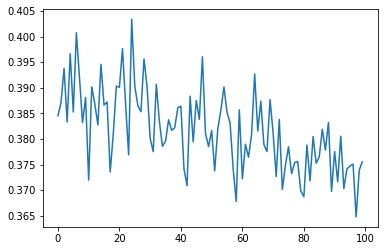

In [135]:
plt.plot(hist_pos_max_l2)

In [ ]:
plt.plot(hist_props_l2)

In [52]:
einops.rearrange(torch.tensor([[i for i in range(10)]] * 10), 'a b -> a n b', n=1)

EinopsError:  Error while processing rearrange-reduction pattern "a b -> a n b".
 Input tensor shape: torch.Size([10, 10]). Additional info: {'n': 1}.
 Identifiers only on one side of expression (should be on both): {'n'}

In [346]:
np.array([
        [1024 + j - i - 1 for j in range(1024) ] 
        for i in range(1024)
    ]).shape

(1024, 1024)

In [245]:
neg_fact.dtype

torch.float32

In [248]:
neg_fact.type(torch.int)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [243]:
returned_vals

array([[[29, 25, 26, ..., 52, 53, 54],
        [33, 29, 30, ..., 56, 57, 58],
        [32, 28, 29, ..., 55, 56, 57],
        ...,
        [ 6,  2,  3, ..., 29, 30, 31],
        [ 5,  1,  2, ..., 28, 29, 30],
        [ 4,  0,  1, ..., 27, 28, 29]],

       [[29, 21, 22, ..., 48, 49, 50],
        [37, 29, 30, ..., 56, 57, 58],
        [36, 28, 29, ..., 55, 56, 57],
        ...,
        [10,  2,  3, ..., 29, 30, 31],
        [ 9,  1,  2, ..., 28, 29, 30],
        [ 8,  0,  1, ..., 27, 28, 29]],

       [[29,  1,  2, ..., 27, 28, 30],
        [57, 29, 30, ..., 55, 56, 58],
        [56, 28, 29, ..., 54, 55, 57],
        ...,
        [31,  3,  4, ..., 29, 30, 32],
        [30,  2,  3, ..., 28, 29, 31],
        [28,  0,  1, ..., 26, 27, 29]],

       ...,

       [[29, 19, 20, ..., 46, 47, 48],
        [39, 29, 30, ..., 56, 57, 58],
        [38, 28, 29, ..., 55, 56, 57],
        ...,
        [12,  2,  3, ..., 29, 30, 31],
        [11,  1,  2, ..., 28, 29, 30],
        [10,  0,  1, ..., 27, 28

In [140]:
hist_props_l2, hist_props_l2_mask

(0.25330349802970886, 0.01613856665790081)

In [141]:
hist_neg_l2, hist_neg_l2_mask

(0.21183332800865173, 0.01289786770939827)

In [142]:
hist_pos_max_l2, hist_pos_max_l2_mask

(0.26231759786605835, 0.019070377573370934)

In [143]:
hist_pos_sum_l2, hist_pos_sum_l2_mask

(66.89488220214844, 4.0206427574157715)

In [44]:
neg_fact = torch.zeros((10 * 480, 100))

In [45]:
l2_none_loss = torch.nn.MSELoss(reduction='none')

In [46]:
neg_pred = l2_none_loss(neg_fact, meanings_pred[:, 20:])

In [47]:
neg_pred.shape

torch.Size([4800, 100])

In [53]:
(neg_pred * loss_mask2).shape

torch.Size([4800, 100])

In [48]:
loss_mask2.shape

torch.Size([4800, 1])

In [51]:
loss_mask2[480,:]

tensor([0.1571])

In [721]:
hidden_states_ext.shape
# hidden_states = einops.repeat(hidden_states, 'r bs e -> (r bs) m e',
# m=TokensEmb.cnt_categories * TokensEmb.cnt_meanings * cnt_negative, )

torch.Size([4800, 120, 180])

In [ ]:
# [4800, 120, 180] = [10(agg) x 16 (bs) 30(seq), 120, 180] 

In [722]:
true_false_batch.shape

torch.Size([4800, 120, 80])

In [705]:
true_false_batch = torch.cat([tokens_embs, negative_batch], axis=1)
true_false_batch.shape

torch.Size([480, 120, 80])

In [692]:
torch.cat([cat_emb_ext2, negative_batch2], axis=-1)

(torch.Size([480, 100, 30]), torch.Size([480, 100, 50]))

In [688]:
cat_emb_ext2[0,0,:]

tensor([-0.1312, -0.0948,  0.2202,  0.1414,  0.2555,  0.4131,  0.3525, -0.3640,
        -0.0362,  0.1579, -0.0383, -0.3065,  0.1020, -0.2766, -0.3648,  0.1268,
         0.3612,  0.1698,  0.0396, -0.1943, -0.0156,  0.1032, -0.1395,  0.2881,
         0.1752, -0.4159, -0.2856, -0.0416, -0.0387,  0.4081],
       grad_fn=<SliceBackward0>)

In [691]:
cat_emb_ext2[0,25,:]

tensor([-0.0022,  0.0484,  0.1391,  0.3842, -0.0386,  0.2287,  0.2664, -0.2704,
        -0.2611,  0.2052,  0.1788,  0.4159,  0.0611, -0.3091, -0.4118,  0.2832,
        -0.1521, -0.4052, -0.1839,  0.3027, -0.3857, -0.3729,  0.0468, -0.3128,
         0.3849,  0.0253,  0.0616, -0.1326, -0.2529, -0.1535],
       grad_fn=<SliceBackward0>)

In [665]:
negative_batch[0].shape

torch.Size([480, 25, 50])

In [550]:
print(tokens_props.shape)
tokens_props = einops.repeat(tokens_props, 'b s f -> (m b s) f', m=10)
tokens_props.shape

torch.Size([16, 30, 4])


torch.Size([4800, 4])

In [552]:
hidden_states[0].shape

torch.Size([480, 180])

In [553]:
hidden_states2 = einops.rearrange(hidden_states, 'r bs e -> (r bs) e')
hidden_states2.shape

torch.Size([4800, 180])

In [554]:
tmp = PropNet.forward(hidden_states2)

In [556]:
tokens_props.shape

torch.Size([4800, 4])

In [557]:
tmp.shape

torch.Size([4800, 4])

In [560]:
l2_mean_loss = torch.nn.MSELoss(reduction='none')

In [561]:
l2_mean_loss(tmp, tokens_props).shape

torch.Size([4800, 4])

In [566]:
loss_mask = torch.tensor([1.0, ] + [0.05] * 29)

In [641]:
loss_mask2 = torch.tensor([(i/10)**1.15 for i in range(1,11)])
loss_mask2

tensor([0.0708, 0.1571, 0.2504, 0.3486, 0.4506, 0.5557, 0.6635, 0.7737, 0.8859,
        1.0000])

In [638]:
loss_mask2 = torch.tensor([(i/10)**1.1 for i in range(1,11)])
loss_mask2 =einops.repeat(loss_mask2, 'h -> (h bs) f', bs=480, f=1)
loss_mask2, loss_mask2.shape

(tensor([[0.0794],
         [0.0794],
         [0.0794],
         ...,
         [1.0000],
         [1.0000],
         [1.0000]]),
 torch.Size([4800, 1]))

In [599]:
loss_mask2 =einops.repeat(loss_mask2, 'h -> (h bs) f', bs=480, f=1)
loss_mask2.shape

torch.Size([4800, 1])

In [604]:
loss_mask2[479,:]

tensor([0.0631])

In [572]:
loss_mask2 = einops.repeat(loss_mask, 's -> (rp b s) f', rp=10, b=16, f=1)
loss_mask2.shape

torch.Size([4800, 1])

In [573]:
loss_mask2[0,:]

tensor([1.])

In [577]:
loss_mask2[30,:]

tensor([1.])

In [562]:
l2_mean_loss(tmp, tokens_props).mean()

tensor(0.1631, grad_fn=<MeanBackward0>)

In [536]:
pd.DataFrame(tokens_props).groupby([0,1,2,3]).size().to_frame('cnt').reset_index()

0  1  2  3  cnt
0  0  0  0  0    6
1  0  0  0  1  394
2  0  0  1  0    5
3  0  0  1  1   19
4  1  0  0  0   12
5  1  0  0  1   40
6  1  1  0  0    1
7  1  1  0  1    3

In [283]:
%%time
ftmp = torch.cat([pos_matrix, props_embs, tokens_embs], axis=4)
ftmp = einops.rearrange(ftmp, 'b s1 s2 m e -> (b s1) (s2 m) e')

CPU times: user 230 ms, sys: 177 ms, total: 408 ms
Wall time: 84.6 ms


In [282]:
%%time
tmp1 = einops.rearrange(pos_matrix, 'b s1 s2 m e -> (b s1) (s2 m) e')
tmp2 = einops.rearrange(props_embs, 'b s1 s2 m e -> (b s1) (s2 m) e')
tmp3 = einops.rearrange(tokens_embs, 'b s1 s2 m e -> (b s1) (s2 m) e')
ftmp = torch.cat([tmp1, tmp2, tmp3], axis=-1)

CPU times: user 433 ms, sys: 454 ms, total: 887 ms
Wall time: 194 ms


In [281]:
%%time
ftmp = torch.cat([tmp1, tmp2, tmp3], axis=-1)

CPU times: user 287 ms, sys: 203 ms, total: 491 ms
Wall time: 127 ms


In [302]:
ftmp.shape

torch.Size([480, 600, 140])

In [303]:
140 * 1.5

210.0

In [304]:
pos_matrix.shape

torch.Size([16, 30, 30, 20, 20])

In [306]:
props_embs.shape

torch.Size([16, 30, 30, 20, 40])

In [307]:
tokens_embs.shape

torch.Size([16, 30, 30, 20, 80])

In [308]:
POS_EMB_SIZE + TITLE_EMB_SIZE + UPPER_EMB_SIZE + PART_EMB_SIZE + END_EMB_SIZE + CAT_EMB_SIZE + MEANING_EMB_SIZE

140

In [309]:
TITLE_EMB_SIZE + UPPER_EMB_SIZE + PART_EMB_SIZE + END_EMB_SIZE + CAT_EMB_SIZE + MEANING_EMB_SIZE

120

In [261]:
_ = einops.rearrange([a, b, c], 'l a b -> a (l b)')

RuntimeError: stack expects each tensor to be equal size, but got [10, 10] at entry 0 and [10, 20] at entry 1

In [252]:
%%time
_ = einops.rearrange([pos_matrix, props_embs, tokens_embs],
                     'l b s1 s2 c e -> b s1 s2 c e'
                    )

RuntimeError: stack expects each tensor to be equal size, but got [128, 30, 30, 20, 20] at entry 0 and [128, 30, 30, 20, 40] at entry 1

In [240]:
pos_matrix[0,0,0,0,:]

tensor([-0.0785, -0.2282, -0.2500,  0.0691, -0.0209, -0.1392,  0.0557,  0.1047,
         0.2192,  0.2140, -0.0413, -0.2430, -0.2490,  0.2573,  0.1218,  0.1201,
        -0.2384,  0.2552,  0.2611,  0.2488], dtype=torch.float64,
       grad_fn=<SliceBackward0>)

In [242]:
pos_matrix[0,0,0,15,:]

tensor([-0.0785, -0.2282, -0.2500,  0.0691, -0.0209, -0.1392,  0.0557,  0.1047,
         0.2192,  0.2140, -0.0413, -0.2430, -0.2490,  0.2573,  0.1218,  0.1201,
        -0.2384,  0.2552,  0.2611,  0.2488], dtype=torch.float64,
       grad_fn=<SliceBackward0>)

In [243]:
pos_matrix[0,1,0,5,]

tensor([-0.0691, -0.0598,  0.2026, -0.2136,  0.0293,  0.2592, -0.0379,  0.2140,
        -0.0849,  0.2218, -0.2666, -0.0397, -0.0484,  0.0893,  0.1081,  0.2116,
        -0.0411, -0.0109,  0.1887, -0.0746], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [206]:
props_embs[0,0,0,0,:] == props_embs[0,0,2,0,:]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [ ]:
props_embs[:,0,0,0,:]

In [25]:
%%time
old_var = TokensEmb.forward(batch)

TokensEmbeding, forward time: 0.4157431125640869
CPU times: user 580 ms, sys: 868 ms, total: 1.45 s
Wall time: 417 ms


In [26]:
%%time
old_var2 = TokensEmb.forward2(extend_batch)

TokensEmbeding, forward2 time: 3.1199347972869873
CPU times: user 2.94 s, sys: 4.99 s, total: 7.93 s
Wall time: 3.16 s


In [27]:
%%time
old_var3 = TokensEmb.forward3(batch)

TokensEmbeding, forward3 time: 0.0433809757232666
CPU times: user 79.1 ms, sys: 115 ms, total: 194 ms
Wall time: 44.4 ms


In [28]:
%%time
old_var4 = TokensEmb.forward4(batch)

TokensEmbeding, forward3 time: 0.032254934310913086
CPU times: user 73.2 ms, sys: 55.6 ms, total: 129 ms
Wall time: 33.1 ms


In [29]:
%%time
old_var5 = TokensEmb.forward5(batch)

cat_emb: torch.Size([128, 30, 20, 30])
cnt_categories: 4
cnt_meanings: 5
cat_emb: torch.Size([128, 30, 20, 50])
TokensEmbeding, forward5 time: 0.03566884994506836
CPU times: user 67.5 ms, sys: 90.3 ms, total: 158 ms
Wall time: 37.1 ms


In [30]:
(old_var == old_var4).sum()

tensor(184320000)

In [797]:
old_var3.shape

torch.Size([128, 30, 30, 20, 80])

In [798]:
128 * 30 * 30 * 20 * 80

184320000

In [704]:
%%time
old_var = PropsEmb.forward(extend_batch[:,:,:,1:])

PropsEmbeding, forward time: 0.24170589447021484
CPU times: user 350 ms, sys: 489 ms, total: 839 ms
Wall time: 262 ms


In [705]:
%%time
old_var2 = PropsEmb.forward2(extend_batch[:,:,:,1:])

PropsEmbeding, forward2 time: 0.6497049331665039
CPU times: user 1.25 s, sys: 1.01 s, total: 2.26 s
Wall time: 650 ms


In [707]:
%%time
old_var3 = PropsEmb.forward3(batch[:,:,1:])

PropsEmbeding, forward3 time: 0.20324993133544922
CPU times: user 224 ms, sys: 410 ms, total: 634 ms
Wall time: 203 ms


In [714]:
%%time
new_var = PropsEmb.forward4(batch[:,:,1:])

PropsEmbeding, forward4 time: 0.0036687850952148438
CPU times: user 2.26 ms, sys: 2.88 ms, total: 5.14 ms
Wall time: 3.81 ms


In [696]:
%%time
old_var = PosEnc.forward(torch.tensor(pos_matrix))

PosEncoding, forward time: 0.06662583351135254
CPU times: user 128 ms, sys: 222 ms, total: 350 ms
Wall time: 69.1 ms


In [697]:
%%time
new_var = PosEnc.forward2(torch.tensor(pos_matrix))

PosEncoding, forward2 time: 0.0031812191009521484
CPU times: user 8.88 ms, sys: 3.81 ms, total: 12.7 ms
Wall time: 3.8 ms


In [599]:
extend_batch.shape, batch.shape

(torch.Size([128, 30, 30]), torch.Size([128, 30]))

In [574]:
a= PropsEmb.forward(extend_batch)

time: 0.13287878036499023


In [575]:
b= PropsEmb.forward2(extend_batch)

time: 0.4492971897125244


In [586]:
c= PropsEmb.forward3(batch[:,:,1:])

time: 0.09531116485595703


In [636]:
a = TokensEmb.forward(batch)

time1: 0.0303800106048584
time2: 0.01830887794494629
time3: 0.19798922538757324
time4: 0.0001437664031982422
time: 0.24683094024658203


In [642]:
b = TokensEmb.forward2(extend_batch)

time1: 1.5422999858856201
time: 2.8998541831970215


In [644]:
torch.randint((128, 30, 5*4, 30+50))

TypeError: randint() received an invalid combination of arguments - got (tuple), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)


In [ ]:
Batch_Size x SeqLen x Cnt_Meanings * CntCats x (CatEmb + MeaningEmb)

In [643]:
len(CAT_SIZES)

4

In [665]:
a=torch.rand((1, 128, 30, 5*4, 30+50)).requires_grad_(True)

In [666]:
%%time
c = a.repeat(30, 1,1,1,1)

CPU times: user 270 ms, sys: 404 ms, total: 674 ms
Wall time: 149 ms


In [667]:
%%time
d = einops.repeat(a, 'b h w s k -> (repeat b) h w s k', repeat=30)

CPU times: user 980 ¬µs, sys: 4.01 ms, total: 4.99 ms
Wall time: 4.37 ms


In [668]:
c.grad_fn

In [671]:
d.grad_fn

In [654]:
import einops

In [653]:
! pip install einops

You should consider upgrading via the '/Users/u14510182/Documents/Wiki_103/venv/bin/python -m pip install --upgrade pip' command.


In [481]:
props_tokens_ems.repeat(30,1,1,1,1).permute(1,0,2,3,4)

torch.Size([128, 30, 30, 20, 120])

In [428]:
props_embs.repeat(20,1,1,1).transpose(0,3)

torch.Size([5, 128, 30, 40])

In [ ]:
tmp.repeat(30,1,1,1,1).permute(1,2,0,3)

In [424]:
props_embs.unsqueeze(-1).shape

torch.Size([128, 30, 40, 1])

In [435]:
tmp = props_embs.repeat(20,1,1,1).permute(1,2,0,3)

In [436]:
tmp.shape

torch.Size([128, 30, 20, 40])

In [442]:
tmp[1, 20, 2, :]

tensor([ 0.0372, -0.3625,  0.1196, -0.6602, -0.5109, -0.3645,  0.4461,  0.4146,
        -0.3136, -0.0255,  0.3199,  0.2844, -0.4189,  0.2136,  0.3882, -0.0892,
         0.0270,  0.1638,  0.4387,  0.6790,  0.2568,  0.5872, -0.1455,  0.5291,
        -0.1140,  0.0748,  0.6403, -0.6560, -0.4452, -0.1790, -0.2137, -0.1390,
        -0.6755, -0.4683, -0.2915,  0.0262,  0.2795,  0.4243, -0.4794, -0.3079],
       dtype=torch.float64, grad_fn=<SliceBackward0>)

In [454]:
props_embs[1, 8, :] == props_embs[1, 9, :]

tensor([False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [450]:
for i in range(29):
    print(i, sum(props_embs[1, i, :] == props_embs[1, i+1, :]))

0 tensor(30)
1 tensor(40)
2 tensor(40)
3 tensor(40)
4 tensor(10)
5 tensor(0)
6 tensor(30)
7 tensor(30)
8 tensor(30)
9 tensor(40)
10 tensor(40)
11 tensor(40)
12 tensor(40)
13 tensor(20)
14 tensor(10)
15 tensor(30)
16 tensor(40)
17 tensor(40)
18 tensor(40)
19 tensor(40)
20 tensor(40)
21 tensor(40)
22 tensor(40)
23 tensor(40)
24 tensor(40)
25 tensor(30)
26 tensor(30)
27 tensor(30)
28 tensor(30)


In [443]:
props_embs[1, 2, :]

tensor([ 0.0372, -0.3625,  0.1196, -0.6602, -0.5109, -0.3645,  0.4461,  0.4146,
        -0.3136, -0.0255,  0.3199,  0.2844, -0.4189,  0.2136,  0.3882, -0.0892,
         0.0270,  0.1638,  0.4387,  0.6790,  0.2568,  0.5872, -0.1455,  0.5291,
        -0.1140,  0.0748,  0.6403, -0.6560, -0.4452, -0.1790, -0.2137, -0.1390,
        -0.6755, -0.4683, -0.2915,  0.0262,  0.2795,  0.4243, -0.4794, -0.3079],
       dtype=torch.float64, grad_fn=<SliceBackward0>)

In [ ]:
tmp[0, 0, 0, :]

1) batch[:,:,0] -> Token_Emb


# Arhitecture

#### –ü—Ä–∏–º–µ—Ä–Ω—ã–π –ø–ª–∞–Ω
1) –ö–∞–∫–∏–º —Ç–æ –æ–±—Ä–∞–∑–æ–º –ø–æ–ª—É—á–∞–µ–º –±–∞—Ç—á –∏–∑ —á–∏—Å–ª–æ–≤—ã—Ö –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π —Ç–æ–∫–µ–Ω–æ–≤ = [Batch_Size, MAX_SEQ_LEN]
2) –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–Ω–µ—Ü –±–∞—Ç—á–∞
3) –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Ü–µ–ª–µ–≤–æ–π —Ç–æ–∫–µ–Ω –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ –±–∞—Ç—á–∞
    –ü–æ–ª—É—á–∞–µ–º —Å–ª–µ–¥—É—é—â–∏–µ –¥–∞–Ω–Ω—ã–µ W0 = [Enc_Pos_0, Token_0], W_Other = [Enc_Pos, Token]
4) –†–∞–Ω–¥–æ–º–æ–º –∏–∑ –±–∞—Ç—á–∞ –≤—ã–±–∏—Ä–∞–µ–º –≥–¥–µ –º—ã –±—É–¥–µ–º —É—á–∏—Ç—ã–≤–∞—Ç—å 


–†–∞—Å—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–∏–º–µ—Ä–µ –æ–¥–Ω–æ–≥–æ "–ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è".
–ü—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ -> Tokens -> Seq (Seq_length –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ —Ä–∞–≤–Ω–∞ MAX_SEQ_LEN)
–°—Ç—Ä–æ–∏–º –º–∞—Ç—Ä–∏—Ü—É Seq_Tokens = [Seq] * Seq_length.
–¢–∞–∫ –∂–µ –±–µ—Ä–µ–º –º–∞—Ç—Ä–∏—Ü—É —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π = [MAX_SEQ_LEN, MAX_SEQ_LEN, POS_EMB_SIZE]
–ò–∑ –Ω–µ–µ –∏–∑–≤–ª–µ–∫–∞–µ–º –ø–æ–¥–º–∞—Ç—Ä–∏—Ü—É Seq_Pos = [Seq_length, Seq_length, POS_EMB_SIZE]

–ü–æ–ª—É—á–∞–µ—Ç—Å—è –¥–≤–µ –º–∞—Ç—Ä–∏—Ü—ã - Seq_Tokens –∏ Seq_Pos
–í—ã–±–∏—Ä–∞–µ–º —Ü–µ–ª–µ–≤–æ–µ —Å–ª–æ–≤–æ, —Ç–æ—á–Ω–µ–µ –µ–≥–æ –ø–æ—Ä—è–¥–∫–æ–≤—ã–π –Ω–æ–º–µ—Ä.
–ü–µ—Ä–µ–º–µ—â–∞–µ–º

In [ ]:
0

–ú–æ–∂–Ω–æ —Ç–∞–∫ –∂–µ –ø–æ–¥–∞–≤–∞—Ç—å –Ω–µ–ø—Ä–∞–≤–∏–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å, —Å —Ü–µ–ª—å—é —á—Ç–æ–± –æ–Ω–∏ –≤—Å–µ —Ä–∞–≤–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–ª–∏ –≤–µ—Ä–Ω—ã–µ.


In [ ]:
input_seq = [token_0, token_1, token_2, token_3]
all_seq = [
    [token_0, token_1, token_2, token_3],
    [mask, token_1, token_2, token_3],
    [token_0, mask, token_2, token_3],
    [token_0, token_1, mask, token_3],
    [token_0, token_1, token_2, mask],
]

for seq in all_seq:
    seq_emb = []
    mask_pos = get_mask_pos(seq)
    
    
    for token_pos, token in enumerate(seq):
        if token != '[MASK]':
            token_info = []
            pos_emb = get_pos_encoding(token_pos, mask_pos)
            for cat in range(CNT_CATS):
                emb_meanings = get_emb(token, cat) # Cnt_Meanings x Emb_Size
                cat_emb = CATS[cat]
                for m in range(Cnt_Meanings):
                    token_info.append(torch.cat([pos_emb, cat_emb, emb_meaning]))
                    
            token_info = torch.cat(token_info) # –ë–æ–ª—å—à–æ–π —Ç–µ–Ω–∑–æ—Ä, –≤ –∫–æ—Ç–æ—Ä–æ–º –∑–∞–µ–Ω–∫–æ–∂–µ–Ω–∞ –≤—Å—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –ø–æ —Ç–æ–∫–µ–Ω—É
            seq_emb.append(token_info)
        
    

In [ ]:
pos_encod_matrix = gen_pos_encodind(MAX_LEN_SEQ)
input_seq = [token_0, token_1, token_2, token_3]
seq_emb = []

for token_pos, token in enumerate(seq):
    token_info = []
    pos_emb = get_pos_encoding(token_pos, mask_pos)
    for cat in range(CNT_CATS):
        emb_meanings = get_emb(token, cat) # Cnt_Meanings x Emb_Size
        cat_emb = CATS[cat]
        for m in range(Cnt_Meanings):
            token_info.append(torch.cat([pos_emb, cat_emb, emb_meaning]))

    token_info = torch.cat(token_info) # –ë–æ–ª—å—à–æ–π —Ç–µ–Ω–∑–æ—Ä, –≤ –∫–æ—Ç–æ—Ä–æ–º –∑–∞–µ–Ω–∫–æ–∂–µ–Ω–∞ –≤—Å—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –ø–æ —Ç–æ–∫–µ–Ω—É
    seq_emb.append(token_info)
    

variant = choose_variant() # –í—ã–±–∏—Ä–∞–µ–µ–º –≤–∞—Ä–∏–∞–Ω—Ç

# –ö–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞—Ä–∏–∞—Ü–∏–π –æ–±—Ä–∞–±–æ—Ç–∫–∏ –æ–¥–Ω–æ–π –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏:
# 1) –ò–∑–º–µ–Ω—è–µ–º –∫–∞–∫–æ–µ-–ª–∏–±–æ —Å–ª–æ–≤–∞:
#      N –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –≤—ã–±—Ä–∞—Ç—å –∏–∑–º–µ–Ω—è–µ–º–æ–µ —Å–ª–æ–≤–æ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏.
#      N –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –≤—ã–±—Ä–∞—Ç—å —Ü–µ–ª–µ–≤–æ–µ —Å–ª–æ–≤–æ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏.
#      N^2 –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤, –µ—Å–ª–∏ –º—ã –µ—â–µ –¥–æ–±–∞–≤–∏–º –æ–ø—Ü–∏—é –æ–ø—É—Å–∫–∞—Ç—å(–º–∞—Å–∫–∏—Ä–æ–≤–∞—Ç—å) –ª–∏ —Ü–µ–ª–µ–≤–æ–µ —Å–ª–æ–≤–æ –≤–æ –≤—Ä–µ–º—è –∞–≥—Ä–µ–≥–∞—Ü–∏–∏ —Ç–æ 2 * N^2
# 2) –ù–µ –∏–∑–º–µ–Ω—è–µ–º —Å–ª–æ–≤–∞ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏:
#      N –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –≤—ã–±—Ä–∞—Ç—å —Ü–µ–ª–µ–≤–æ–µ —Å–ª–æ–≤–æ.
#      2 - –æ–ø—É—Å–∫–∞–µ–º –∏–ª–∏ –Ω–µ—Ç —Ü–µ–ª–µ–≤–æ–µ —Å–ª–æ–≤–æ –ø—Ä–∏ –∞–≥–≥—Ä–µ–≥–∞—Ü–∏–∏
#